In [1]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm
from segtok import tokenizer
from utils import *
import hickle

In [2]:
# Key Hyperparameters
enable_orig = "orig"
enable_aug = False
enable_aug3 = False
max_training_samples = 100000
max_tokenized_length = 64
num_sentences = 10
valid_percent = 0.01

batch_size_finetuning = 32
epochs_finetuning = 1
lr_finetuning = 1e-5

batch_size = 128
epochs = 20
main_model_lr = 1e-5

lstm_hidden_size = 1024
regressive_style_finetuning = False

experiment_id = f"test"

In [3]:
# Parameters
regressive_style_finetuning = True
enable_orig = False
enable_aug = False
enable_aug3 = True
max_training_samples = 200000
lstm_hidden_size = 512
epochs = 20
experiment_id = "classification-sentence-embeddings-regressive_style_finetuning-True-enable_orig-False-enable_aug-False-enable_aug3-True-max_training_samples-200000-lstm_hidden_size-512-epochs-20"


In [4]:
import os
experiment_dir = f"completed-experiments/{experiment_id}"
if not os.path.exists(experiment_dir):
    os.makedirs(experiment_dir)

In [5]:
from data_parsing import *
data = load_dataset("./yelp_review_training_dataset.jsonl")

In [6]:
from training_utils import split_train_validation
from text_preprocessing import preprocess
import random

def get_train_valid():
    orig_train_x, valid_x, orig_train_y, valid_y = split_train_validation(data, 0.01)
    train_x = []
    train_y = []

    if enable_aug:
        aug_data = load_gen_dataset("./new_data.json") + load_gen_dataset("./new_data2.json")
        train_x += [i[0] for i in aug_data]
        train_y += [i[1] for i in aug_data]

    if enable_aug3:
        aug_data3 = load_gen_dataset("./new_data3.json")
        train_x += [i[0] for i in aug_data3]
        train_y += [i[1] for i in aug_data3]
        
    if enable_orig:
        train_x += orig_train_x
        train_y += orig_train_y
    
    train_x = train_x[:max_training_samples]
    train_y = train_y[:max_training_samples]

    if enable_orig == "preprocess":
        train_x = preprocess(train_x)
        valid_x = preprocess(valid_x)    

    paired_train = list(zip(train_x, train_y))
    random.shuffle(paired_train)
    train_x = [i[0] for i in paired_train]
    train_y = [i[1] for i in paired_train]

    return [x.encode("utf-8") for x in train_x], [x.encode("utf-8") for x in valid_x], train_y, valid_y

split_key = f"cache-core/split-data-{valid_percent}-orig-{enable_orig}-aug12-{enable_aug}-aug3-{enable_aug3}-max-{max_training_samples}"
train_x, valid_x, train_y, valid_y = memo_load(
    get_train_valid,
    split_key
)
split_hash = hash_file(split_key + ".hkl")

train_x = [x.decode("utf-8") for x in train_x]
valid_x = [x.decode("utf-8") for x in valid_x]

In [7]:
print(len(train_x))
print(len(train_y))
print(len(valid_x))
print(len(valid_y))

5000
5000
5336
5336


In [8]:
import torch as th

device = th.device("cuda" if th.cuda.is_available() else "cpu")
print(device)

from spacy.lang.en import English
nlp = English()
nlp.add_pipe("sentencizer")

cuda


In [9]:
from transformers import BertTokenizerFast, BertForSequenceClassification
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

In [10]:
# fine tune the BERT
import numpy as np

def get_finetuning_data():
    train_x_numerized = []
    train_x_mask = []
    train_y_per_sentence = []
    for i, text in tqdm(list(enumerate(train_x))):
        doc = nlp(text)
        sents = [str(sent) for sent in doc.sents]
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            train_x_numerized.append(tokenized.ids)
            train_x_mask.append(tokenized.attention_mask)
            train_y_per_sentence.append(train_y[i])

    valid_x_numerized = []
    valid_x_mask = []
    valid_y_per_sentence = []
    for i, text in tqdm(list(enumerate(valid_x))):
        doc = nlp(text)
        sents = [str(sent) for sent in doc.sents]
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            valid_x_numerized.append(tokenized.ids)
            valid_x_mask.append(tokenized.attention_mask)
            valid_y_per_sentence.append(valid_y[i])

    train_x_numerized = np.array(train_x_numerized)
    train_x_mask = np.array(train_x_mask)
    train_y_per_sentence = np.array(train_y_per_sentence)
    valid_x_numerized = np.array(valid_x_numerized)
    valid_x_mask = np.array(valid_x_mask)
    valid_y_per_sentence = np.array(valid_y_per_sentence)
    return train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence

from utils import memo_load
finetuning_data_key = f"cache-core/training-data-finetuning-max-tokens-{max_tokenized_length}-split-{split_hash}"
(train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence) = memo_load(
    lambda: get_finetuning_data(),
    finetuning_data_key
)
finetuning_data_hash = hash_file(finetuning_data_key + ".hkl")

In [11]:
from model import ReviewPredictionModel
import torch.optim as optim

def train_finetuning():
    if regressive_style_finetuning:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1)
    else:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=9)

    model_to_train_finetuning = ReviewPredictionModel(0, max_tokenized_length, regressive_bert_style=regressive_style_finetuning)
    model_to_train_finetuning.transformer = embedding_bert
    model_to_train_finetuning.to(device)
    optimizer = optim.Adam(model_to_train_finetuning.parameters(), lr=lr_finetuning)
    
    training_accuracies_finetuning, validation_accuracies_finetuning = run_training_loop(
        model_to_train_finetuning, optimizer, device,
        batch_size_finetuning, epochs_finetuning,
        train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence,
        max_validation_examples=256,
        model_id=experiment_id, tag="finetuning"
    )
    
    return embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning

def store_finetuning(tup, folder):
    embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning = tup
    th.save(embedding_bert.state_dict(), f"{folder}/model.pt")
    hickle.dump((training_accuracies_finetuning, validation_accuracies_finetuning), f"{folder}/accuracies.hkl", mode="w")

def load_finetuning(folder):
    if regressive_style_finetuning:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1)
    else:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=9)
    embedding_bert.load_state_dict(th.load(f"{folder}/model.pt"))
    embedding_bert.eval()
    embedding_bert.to(device)
    training_accuracies_finetuning, validation_accuracies_finetuning = hickle.load(f"{folder}/accuracies.hkl")
    return embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning

In [12]:
from training_utils import run_training_loop

from utils import memo_load
finetuning_model_key = f"cache-core/finetuning-batch-size-{batch_size_finetuning}-epochs-{epochs_finetuning}-lr-{lr_finetuning}-regressive-{regressive_style_finetuning}-data-{finetuning_data_hash}"
embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning = manual_memo(
    train_finetuning, store_finetuning, load_finetuning,
    finetuning_model_key
)

th.save(embedding_bert.state_dict(), f"{experiment_dir}/finetuned-bert.pt")
hickle.dump((training_accuracies_finetuning, validation_accuracies_finetuning), f"{experiment_dir}/finetuning-accuracies.hkl", mode="w")

finetuning_model_hash = hash_file(finetuning_model_key + "/model.pt")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


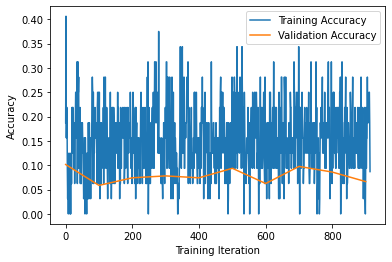

In [13]:
import matplotlib.pyplot as plt
plt.plot(range(len(training_accuracies_finetuning)), training_accuracies_finetuning, label = "Training Accuracy")
plt.plot(list(map(lambda x: x * 100, range(len(validation_accuracies_finetuning)))), validation_accuracies_finetuning, label = "Validation Accuracy")
plt.xlabel("Training Iteration")
plt.ylabel("Accuracy")
plt.legend()

In [14]:
import torch as th
import numpy as np

embedding_bert.to(device)

def get_embeds(x_data):
    concatted_shape = None
    pad_value = None
    embeds = []
    for text in tqdm(x_data):
        doc = nlp(text)
        embeddeds = []
        sents = list(doc.sents)
        all_tokenized = []
        for sentence in sents[:num_sentences]:
            sentence = str(sentence)
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            all_tokenized.append(tokenized.ids)
        
        with th.no_grad():
            sentence_tensor = th.tensor(all_tokenized).to(device)
            concatted = np.concatenate([
                # take output corresponding to CLS
                embedding_bert.bert(sentence_tensor, output_hidden_states=True, return_dict=True)[1].cpu().numpy(),
                np.zeros((len(all_tokenized), 1))
            ], axis=1)
            
            if not concatted_shape:
                concatted_shape = concatted.shape
                pad_value = np.zeros(concatted_shape[1])
                pad_value[-1] = 1
            
            embeddeds += list(concatted)

        if len(sents) < num_sentences:
            embeddeds += [pad_value] * (num_sentences - len(sents))

        embeds.append(embeddeds)
    return np.array(embeds)

main_data_key = f"cache-core/training-data-main-max-tokens-{max_tokenized_length}-split-{split_hash}-finetuned-{finetuning_model_hash}"
train_x_embeds, valid_x_embeds = memo_load(
    lambda: (
        get_embeds(train_x),
        get_embeds(valid_x)
    ),
    main_data_key
)
main_data_hash = hash_file(main_data_key + ".hkl")

In [15]:
from model_sentence_lstm import ReviewPredictionModel
import torch as th
import torch.optim as optim

def train_main():
    model_to_train = ReviewPredictionModel(train_x_embeds.shape[2], lstm_hidden_size)
    model_to_train.to(device)
    optimizer = optim.Adam(model_to_train.parameters(), lr=main_model_lr)
    
    training_accuracies, validation_accuracies = run_training_loop(
        model_to_train, optimizer, device,
        batch_size, epochs,
        train_x_embeds, None, np.array(train_y), valid_x_embeds, None, np.array(valid_y),
        model_id=experiment_id, max_validation_examples=512
    )
    
    return model_to_train, training_accuracies, validation_accuracies

def store_main(tup, folder):
    model_to_train, training_accuracies, validation_accuracies = tup
    th.save(model_to_train.state_dict(), f"{folder}/model.pt")
    hickle.dump((training_accuracies, validation_accuracies), f"{folder}/accuracies.hkl", mode="w")

def load_main(folder):
    model_to_train = ReviewPredictionModel(train_x_embeds.shape[2], lstm_hidden_size)
    model_to_train.load_state_dict(th.load(f"{folder}/model.pt"))
    model_to_train.eval()
    model_to_train.to(device)
    training_accuracies, validation_accuracies = hickle.load(f"{folder}/accuracies.hkl")
    return model_to_train, training_accuracies, validation_accuracies

In [16]:
from training_utils import run_training_loop

main_model_key = f"cache-core/main-model-lstm-{lstm_hidden_size}-lr-{main_model_lr}-batch-size-{batch_size}-epochs-{epochs}-data-{main_data_hash}"
main_model, training_accuracies, validation_accuracies = manual_memo(
    train_main, store_main, load_main,
    main_model_key
)

th.save(main_model.state_dict(), f"{experiment_dir}/main-model.pt")
hickle.dump((training_accuracies, validation_accuracies), f"{experiment_dir}/main-accuracies.hkl", mode="w")

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 0 Loss: 2.202 Validation Loss: 2.169 Accuracy: 0.000 Validation Accuracy: 0.383:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 1 Loss: 2.202 Validation Loss: 2.169 Accuracy: 0.000 Validation Accuracy: 0.383:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 2 Loss: 2.202 Validation Loss: 2.169 Accuracy: 0.000 Validation Accuracy: 0.383:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 3 Loss: 2.201 Validation Loss: 2.169 Accuracy: 0.000 Validation Accuracy: 0.383:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 4 Loss: 2.200 Validation Loss: 2.169 Accuracy: 0.000 Validation Accuracy: 0.383:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 5 Loss: 2.198 Validation Loss: 2.169 Accuracy: 0.000 Validation Accuracy: 0.383:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 6 Loss: 2.197 Validation Loss: 2.169 Accuracy: 0.000 Validation Accuracy: 0.383:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 7 Loss: 2.196 Validation Loss: 2.169 Accuracy: 0.000 Validation Accuracy: 0.383:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 8 Loss: 2.194 Validation Loss: 2.169 Accuracy: 0.000 Validation Accuracy: 0.383:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 9 Loss: 2.193 Validation Loss: 2.169 Accuracy: 0.000 Validation Accuracy: 0.383:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 10 Loss: 2.191 Validation Loss: 2.169 Accuracy: 0.000 Validation Accuracy: 0.383:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 11 Loss: 2.189 Validation Loss: 2.169 Accuracy: 0.000 Validation Accuracy: 0.383:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 12 Loss: 2.188 Validation Loss: 2.169 Accuracy: 0.000 Validation Accuracy: 0.383:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 13 Loss: 2.187 Validation Loss: 2.169 Accuracy: 0.000 Validation Accuracy: 0.383:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 14 Loss: 2.185 Validation Loss: 2.169 Accuracy: 0.000 Validation Accuracy: 0.383:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 15 Loss: 2.183 Validation Loss: 2.169 Accuracy: 0.009 Validation Accuracy: 0.383:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 16 Loss: 2.182 Validation Loss: 2.169 Accuracy: 0.018 Validation Accuracy: 0.383:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 17 Loss: 2.180 Validation Loss: 2.169 Accuracy: 0.029 Validation Accuracy: 0.383:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 17 Loss: 2.180 Validation Loss: 2.169 Accuracy: 0.029 Validation Accuracy: 0.383:  45%|████▌     | 18/40 [00:00<00:00, 172.28it/s]

Epoch: 0 Iteration: 18 Loss: 2.179 Validation Loss: 2.169 Accuracy: 0.045 Validation Accuracy: 0.383:  45%|████▌     | 18/40 [00:00<00:00, 172.28it/s]

Epoch: 0 Iteration: 19 Loss: 2.177 Validation Loss: 2.169 Accuracy: 0.063 Validation Accuracy: 0.383:  45%|████▌     | 18/40 [00:00<00:00, 172.28it/s]

Epoch: 0 Iteration: 20 Loss: 2.174 Validation Loss: 2.169 Accuracy: 0.087 Validation Accuracy: 0.383:  45%|████▌     | 18/40 [00:00<00:00, 172.28it/s]

Epoch: 0 Iteration: 21 Loss: 2.171 Validation Loss: 2.169 Accuracy: 0.109 Validation Accuracy: 0.383:  45%|████▌     | 18/40 [00:00<00:00, 172.28it/s]

Epoch: 0 Iteration: 22 Loss: 2.168 Validation Loss: 2.169 Accuracy: 0.129 Validation Accuracy: 0.383:  45%|████▌     | 18/40 [00:00<00:00, 172.28it/s]

Epoch: 0 Iteration: 23 Loss: 2.165 Validation Loss: 2.169 Accuracy: 0.148 Validation Accuracy: 0.383:  45%|████▌     | 18/40 [00:00<00:00, 172.28it/s]

Epoch: 0 Iteration: 24 Loss: 2.162 Validation Loss: 2.169 Accuracy: 0.172 Validation Accuracy: 0.383:  45%|████▌     | 18/40 [00:00<00:00, 172.28it/s]

Epoch: 0 Iteration: 25 Loss: 2.159 Validation Loss: 2.169 Accuracy: 0.181 Validation Accuracy: 0.383:  45%|████▌     | 18/40 [00:00<00:00, 172.28it/s]

Epoch: 0 Iteration: 26 Loss: 2.157 Validation Loss: 2.169 Accuracy: 0.197 Validation Accuracy: 0.383:  45%|████▌     | 18/40 [00:00<00:00, 172.28it/s]

Epoch: 0 Iteration: 27 Loss: 2.154 Validation Loss: 2.169 Accuracy: 0.216 Validation Accuracy: 0.383:  45%|████▌     | 18/40 [00:00<00:00, 172.28it/s]

Epoch: 0 Iteration: 28 Loss: 2.151 Validation Loss: 2.169 Accuracy: 0.227 Validation Accuracy: 0.383:  45%|████▌     | 18/40 [00:00<00:00, 172.28it/s]

Epoch: 0 Iteration: 29 Loss: 2.147 Validation Loss: 2.169 Accuracy: 0.242 Validation Accuracy: 0.383:  45%|████▌     | 18/40 [00:00<00:00, 172.28it/s]

Epoch: 0 Iteration: 30 Loss: 2.144 Validation Loss: 2.169 Accuracy: 0.246 Validation Accuracy: 0.383:  45%|████▌     | 18/40 [00:00<00:00, 172.28it/s]

Epoch: 0 Iteration: 31 Loss: 2.141 Validation Loss: 2.169 Accuracy: 0.252 Validation Accuracy: 0.383:  45%|████▌     | 18/40 [00:00<00:00, 172.28it/s]

Epoch: 0 Iteration: 32 Loss: 2.138 Validation Loss: 2.169 Accuracy: 0.263 Validation Accuracy: 0.383:  45%|████▌     | 18/40 [00:00<00:00, 172.28it/s]

Epoch: 0 Iteration: 33 Loss: 2.135 Validation Loss: 2.169 Accuracy: 0.274 Validation Accuracy: 0.383:  45%|████▌     | 18/40 [00:00<00:00, 172.28it/s]

Epoch: 0 Iteration: 34 Loss: 2.131 Validation Loss: 2.169 Accuracy: 0.279 Validation Accuracy: 0.383:  45%|████▌     | 18/40 [00:00<00:00, 172.28it/s]

Epoch: 0 Iteration: 35 Loss: 2.127 Validation Loss: 2.169 Accuracy: 0.295 Validation Accuracy: 0.383:  45%|████▌     | 18/40 [00:00<00:00, 172.28it/s]

Epoch: 0 Iteration: 36 Loss: 2.124 Validation Loss: 2.169 Accuracy: 0.303 Validation Accuracy: 0.383:  45%|████▌     | 18/40 [00:00<00:00, 172.28it/s]

Epoch: 0 Iteration: 37 Loss: 2.121 Validation Loss: 2.169 Accuracy: 0.317 Validation Accuracy: 0.383:  45%|████▌     | 18/40 [00:00<00:00, 172.28it/s]

Epoch: 0 Iteration: 38 Loss: 2.117 Validation Loss: 2.169 Accuracy: 0.328 Validation Accuracy: 0.383:  45%|████▌     | 18/40 [00:00<00:00, 172.28it/s]

Epoch: 0 Iteration: 39 Loss: 2.109 Validation Loss: 2.169 Accuracy: 0.345 Validation Accuracy: 0.383:  45%|████▌     | 18/40 [00:00<00:00, 172.28it/s]

Epoch: 0 Iteration: 39 Loss: 2.109 Validation Loss: 2.169 Accuracy: 0.345 Validation Accuracy: 0.383: 100%|██████████| 40/40 [00:00<00:00, 198.36it/s]

Epoch: 0 Iteration: 39 Loss: 2.109 Validation Loss: 2.169 Accuracy: 0.345 Validation Accuracy: 0.383: 100%|██████████| 40/40 [00:00<00:00, 194.06it/s]


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 0 Loss: 2.105 Validation Loss: 2.185 Accuracy: 0.354 Validation Accuracy: 0.271:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 1 Loss: 2.101 Validation Loss: 2.185 Accuracy: 0.366 Validation Accuracy: 0.271:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 2 Loss: 2.098 Validation Loss: 2.185 Accuracy: 0.374 Validation Accuracy: 0.271:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 3 Loss: 2.096 Validation Loss: 2.185 Accuracy: 0.377 Validation Accuracy: 0.271:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 4 Loss: 2.093 Validation Loss: 2.185 Accuracy: 0.379 Validation Accuracy: 0.271:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 5 Loss: 2.088 Validation Loss: 2.185 Accuracy: 0.380 Validation Accuracy: 0.271:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 6 Loss: 2.085 Validation Loss: 2.185 Accuracy: 0.386 Validation Accuracy: 0.271:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 7 Loss: 2.081 Validation Loss: 2.185 Accuracy: 0.382 Validation Accuracy: 0.271:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 8 Loss: 2.079 Validation Loss: 2.185 Accuracy: 0.381 Validation Accuracy: 0.271:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 9 Loss: 2.075 Validation Loss: 2.185 Accuracy: 0.379 Validation Accuracy: 0.271:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 10 Loss: 2.073 Validation Loss: 2.185 Accuracy: 0.385 Validation Accuracy: 0.271:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 11 Loss: 2.070 Validation Loss: 2.185 Accuracy: 0.391 Validation Accuracy: 0.271:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 12 Loss: 2.068 Validation Loss: 2.185 Accuracy: 0.401 Validation Accuracy: 0.271:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 13 Loss: 2.065 Validation Loss: 2.185 Accuracy: 0.414 Validation Accuracy: 0.271:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 14 Loss: 2.062 Validation Loss: 2.185 Accuracy: 0.430 Validation Accuracy: 0.271:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 15 Loss: 2.061 Validation Loss: 2.185 Accuracy: 0.445 Validation Accuracy: 0.271:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 16 Loss: 2.058 Validation Loss: 2.185 Accuracy: 0.448 Validation Accuracy: 0.271:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 17 Loss: 2.055 Validation Loss: 2.185 Accuracy: 0.448 Validation Accuracy: 0.271:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 18 Loss: 2.053 Validation Loss: 2.185 Accuracy: 0.447 Validation Accuracy: 0.271:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 19 Loss: 2.054 Validation Loss: 2.185 Accuracy: 0.450 Validation Accuracy: 0.271:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 19 Loss: 2.054 Validation Loss: 2.185 Accuracy: 0.450 Validation Accuracy: 0.271:  50%|█████     | 20/40 [00:00<00:00, 195.27it/s]

Epoch: 1 Iteration: 20 Loss: 2.053 Validation Loss: 2.185 Accuracy: 0.453 Validation Accuracy: 0.271:  50%|█████     | 20/40 [00:00<00:00, 195.27it/s]

Epoch: 1 Iteration: 21 Loss: 2.051 Validation Loss: 2.185 Accuracy: 0.448 Validation Accuracy: 0.271:  50%|█████     | 20/40 [00:00<00:00, 195.27it/s]

Epoch: 1 Iteration: 22 Loss: 2.047 Validation Loss: 2.185 Accuracy: 0.444 Validation Accuracy: 0.271:  50%|█████     | 20/40 [00:00<00:00, 195.27it/s]

Epoch: 1 Iteration: 23 Loss: 2.042 Validation Loss: 2.185 Accuracy: 0.445 Validation Accuracy: 0.271:  50%|█████     | 20/40 [00:00<00:00, 195.27it/s]

Epoch: 1 Iteration: 24 Loss: 2.037 Validation Loss: 2.185 Accuracy: 0.444 Validation Accuracy: 0.271:  50%|█████     | 20/40 [00:00<00:00, 195.27it/s]

Epoch: 1 Iteration: 25 Loss: 2.034 Validation Loss: 2.185 Accuracy: 0.445 Validation Accuracy: 0.271:  50%|█████     | 20/40 [00:00<00:00, 195.27it/s]

Epoch: 1 Iteration: 26 Loss: 2.030 Validation Loss: 2.185 Accuracy: 0.447 Validation Accuracy: 0.271:  50%|█████     | 20/40 [00:00<00:00, 195.27it/s]

Epoch: 1 Iteration: 27 Loss: 2.027 Validation Loss: 2.185 Accuracy: 0.459 Validation Accuracy: 0.271:  50%|█████     | 20/40 [00:00<00:00, 195.27it/s]

Epoch: 1 Iteration: 28 Loss: 2.023 Validation Loss: 2.185 Accuracy: 0.468 Validation Accuracy: 0.271:  50%|█████     | 20/40 [00:00<00:00, 195.27it/s]

Epoch: 1 Iteration: 29 Loss: 2.020 Validation Loss: 2.185 Accuracy: 0.466 Validation Accuracy: 0.271:  50%|█████     | 20/40 [00:00<00:00, 195.27it/s]

Epoch: 1 Iteration: 30 Loss: 2.016 Validation Loss: 2.185 Accuracy: 0.459 Validation Accuracy: 0.271:  50%|█████     | 20/40 [00:00<00:00, 195.27it/s]

Epoch: 1 Iteration: 31 Loss: 2.012 Validation Loss: 2.185 Accuracy: 0.469 Validation Accuracy: 0.271:  50%|█████     | 20/40 [00:00<00:00, 195.27it/s]

Epoch: 1 Iteration: 32 Loss: 2.008 Validation Loss: 2.185 Accuracy: 0.469 Validation Accuracy: 0.271:  50%|█████     | 20/40 [00:00<00:00, 195.27it/s]

Epoch: 1 Iteration: 33 Loss: 2.006 Validation Loss: 2.185 Accuracy: 0.473 Validation Accuracy: 0.271:  50%|█████     | 20/40 [00:00<00:00, 195.27it/s]

Epoch: 1 Iteration: 34 Loss: 2.002 Validation Loss: 2.185 Accuracy: 0.473 Validation Accuracy: 0.271:  50%|█████     | 20/40 [00:00<00:00, 195.27it/s]

Epoch: 1 Iteration: 35 Loss: 1.999 Validation Loss: 2.185 Accuracy: 0.472 Validation Accuracy: 0.271:  50%|█████     | 20/40 [00:00<00:00, 195.27it/s]

Epoch: 1 Iteration: 36 Loss: 1.994 Validation Loss: 2.185 Accuracy: 0.484 Validation Accuracy: 0.271:  50%|█████     | 20/40 [00:00<00:00, 195.27it/s]

Epoch: 1 Iteration: 37 Loss: 1.988 Validation Loss: 2.185 Accuracy: 0.477 Validation Accuracy: 0.271:  50%|█████     | 20/40 [00:00<00:00, 195.27it/s]

Epoch: 1 Iteration: 38 Loss: 1.980 Validation Loss: 2.185 Accuracy: 0.481 Validation Accuracy: 0.271:  50%|█████     | 20/40 [00:00<00:00, 195.27it/s]

Epoch: 1 Iteration: 39 Loss: 1.972 Validation Loss: 2.185 Accuracy: 0.483 Validation Accuracy: 0.271:  50%|█████     | 20/40 [00:00<00:00, 195.27it/s]

Epoch: 1 Iteration: 39 Loss: 1.972 Validation Loss: 2.185 Accuracy: 0.483 Validation Accuracy: 0.271: 100%|██████████| 40/40 [00:00<00:00, 206.64it/s]


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 0 Loss: 1.965 Validation Loss: 2.233 Accuracy: 0.494 Validation Accuracy: 0.229:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 1 Loss: 1.960 Validation Loss: 2.233 Accuracy: 0.497 Validation Accuracy: 0.229:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 2 Loss: 1.955 Validation Loss: 2.233 Accuracy: 0.499 Validation Accuracy: 0.229:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 3 Loss: 1.953 Validation Loss: 2.233 Accuracy: 0.502 Validation Accuracy: 0.229:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 4 Loss: 1.951 Validation Loss: 2.233 Accuracy: 0.503 Validation Accuracy: 0.229:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 5 Loss: 1.950 Validation Loss: 2.233 Accuracy: 0.502 Validation Accuracy: 0.229:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 6 Loss: 1.945 Validation Loss: 2.233 Accuracy: 0.492 Validation Accuracy: 0.229:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 7 Loss: 1.941 Validation Loss: 2.233 Accuracy: 0.499 Validation Accuracy: 0.229:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 8 Loss: 1.936 Validation Loss: 2.233 Accuracy: 0.493 Validation Accuracy: 0.229:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 9 Loss: 1.933 Validation Loss: 2.233 Accuracy: 0.492 Validation Accuracy: 0.229:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 10 Loss: 1.928 Validation Loss: 2.233 Accuracy: 0.487 Validation Accuracy: 0.229:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 11 Loss: 1.924 Validation Loss: 2.233 Accuracy: 0.479 Validation Accuracy: 0.229:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 12 Loss: 1.918 Validation Loss: 2.233 Accuracy: 0.484 Validation Accuracy: 0.229:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 13 Loss: 1.910 Validation Loss: 2.233 Accuracy: 0.487 Validation Accuracy: 0.229:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 14 Loss: 1.906 Validation Loss: 2.233 Accuracy: 0.487 Validation Accuracy: 0.229:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 15 Loss: 1.901 Validation Loss: 2.233 Accuracy: 0.490 Validation Accuracy: 0.229:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 16 Loss: 1.899 Validation Loss: 2.233 Accuracy: 0.497 Validation Accuracy: 0.229:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 17 Loss: 1.894 Validation Loss: 2.233 Accuracy: 0.501 Validation Accuracy: 0.229:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 18 Loss: 1.892 Validation Loss: 2.233 Accuracy: 0.502 Validation Accuracy: 0.229:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 19 Loss: 1.894 Validation Loss: 2.233 Accuracy: 0.499 Validation Accuracy: 0.229:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 19 Loss: 1.894 Validation Loss: 2.233 Accuracy: 0.499 Validation Accuracy: 0.229:  50%|█████     | 20/40 [00:00<00:00, 196.01it/s]

Epoch: 2 Iteration: 20 Loss: 1.888 Validation Loss: 2.233 Accuracy: 0.506 Validation Accuracy: 0.229:  50%|█████     | 20/40 [00:00<00:00, 196.01it/s]

Epoch: 2 Iteration: 21 Loss: 1.884 Validation Loss: 2.233 Accuracy: 0.517 Validation Accuracy: 0.229:  50%|█████     | 20/40 [00:00<00:00, 196.01it/s]

Epoch: 2 Iteration: 22 Loss: 1.883 Validation Loss: 2.233 Accuracy: 0.503 Validation Accuracy: 0.229:  50%|█████     | 20/40 [00:00<00:00, 196.01it/s]

Epoch: 2 Iteration: 23 Loss: 1.877 Validation Loss: 2.233 Accuracy: 0.496 Validation Accuracy: 0.229:  50%|█████     | 20/40 [00:00<00:00, 196.01it/s]

Epoch: 2 Iteration: 24 Loss: 1.867 Validation Loss: 2.233 Accuracy: 0.505 Validation Accuracy: 0.229:  50%|█████     | 20/40 [00:00<00:00, 196.01it/s]

Epoch: 2 Iteration: 25 Loss: 1.859 Validation Loss: 2.233 Accuracy: 0.505 Validation Accuracy: 0.229:  50%|█████     | 20/40 [00:00<00:00, 196.01it/s]

Epoch: 2 Iteration: 26 Loss: 1.857 Validation Loss: 2.233 Accuracy: 0.492 Validation Accuracy: 0.229:  50%|█████     | 20/40 [00:00<00:00, 196.01it/s]

Epoch: 2 Iteration: 27 Loss: 1.852 Validation Loss: 2.233 Accuracy: 0.484 Validation Accuracy: 0.229:  50%|█████     | 20/40 [00:00<00:00, 196.01it/s]

Epoch: 2 Iteration: 28 Loss: 1.846 Validation Loss: 2.233 Accuracy: 0.491 Validation Accuracy: 0.229:  50%|█████     | 20/40 [00:00<00:00, 196.01it/s]

Epoch: 2 Iteration: 29 Loss: 1.840 Validation Loss: 2.233 Accuracy: 0.495 Validation Accuracy: 0.229:  50%|█████     | 20/40 [00:00<00:00, 196.01it/s]

Epoch: 2 Iteration: 30 Loss: 1.833 Validation Loss: 2.233 Accuracy: 0.492 Validation Accuracy: 0.229:  50%|█████     | 20/40 [00:00<00:00, 196.01it/s]

Epoch: 2 Iteration: 31 Loss: 1.825 Validation Loss: 2.233 Accuracy: 0.491 Validation Accuracy: 0.229:  50%|█████     | 20/40 [00:00<00:00, 196.01it/s]

Epoch: 2 Iteration: 32 Loss: 1.819 Validation Loss: 2.233 Accuracy: 0.509 Validation Accuracy: 0.229:  50%|█████     | 20/40 [00:00<00:00, 196.01it/s]

Epoch: 2 Iteration: 33 Loss: 1.815 Validation Loss: 2.233 Accuracy: 0.517 Validation Accuracy: 0.229:  50%|█████     | 20/40 [00:00<00:00, 196.01it/s]

Epoch: 2 Iteration: 34 Loss: 1.813 Validation Loss: 2.233 Accuracy: 0.513 Validation Accuracy: 0.229:  50%|█████     | 20/40 [00:00<00:00, 196.01it/s]

Epoch: 2 Iteration: 35 Loss: 1.806 Validation Loss: 2.233 Accuracy: 0.510 Validation Accuracy: 0.229:  50%|█████     | 20/40 [00:00<00:00, 196.01it/s]

Epoch: 2 Iteration: 36 Loss: 1.797 Validation Loss: 2.233 Accuracy: 0.523 Validation Accuracy: 0.229:  50%|█████     | 20/40 [00:00<00:00, 196.01it/s]

Epoch: 2 Iteration: 37 Loss: 1.794 Validation Loss: 2.233 Accuracy: 0.527 Validation Accuracy: 0.229:  50%|█████     | 20/40 [00:00<00:00, 196.01it/s]

Epoch: 2 Iteration: 38 Loss: 1.787 Validation Loss: 2.233 Accuracy: 0.521 Validation Accuracy: 0.229:  50%|█████     | 20/40 [00:00<00:00, 196.01it/s]

Epoch: 2 Iteration: 39 Loss: 1.787 Validation Loss: 2.233 Accuracy: 0.520 Validation Accuracy: 0.229:  50%|█████     | 20/40 [00:00<00:00, 196.01it/s]

Epoch: 2 Iteration: 39 Loss: 1.787 Validation Loss: 2.233 Accuracy: 0.520 Validation Accuracy: 0.229: 100%|██████████| 40/40 [00:00<00:00, 206.77it/s]


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 0 Loss: 1.782 Validation Loss: 2.400 Accuracy: 0.516 Validation Accuracy: 0.206:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 1 Loss: 1.776 Validation Loss: 2.400 Accuracy: 0.512 Validation Accuracy: 0.206:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 2 Loss: 1.765 Validation Loss: 2.400 Accuracy: 0.509 Validation Accuracy: 0.206:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 3 Loss: 1.759 Validation Loss: 2.400 Accuracy: 0.508 Validation Accuracy: 0.206:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 4 Loss: 1.756 Validation Loss: 2.400 Accuracy: 0.510 Validation Accuracy: 0.206:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 5 Loss: 1.754 Validation Loss: 2.400 Accuracy: 0.505 Validation Accuracy: 0.206:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 6 Loss: 1.745 Validation Loss: 2.400 Accuracy: 0.495 Validation Accuracy: 0.206:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 7 Loss: 1.742 Validation Loss: 2.400 Accuracy: 0.490 Validation Accuracy: 0.206:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 8 Loss: 1.735 Validation Loss: 2.400 Accuracy: 0.487 Validation Accuracy: 0.206:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 9 Loss: 1.729 Validation Loss: 2.400 Accuracy: 0.491 Validation Accuracy: 0.206:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 10 Loss: 1.721 Validation Loss: 2.400 Accuracy: 0.495 Validation Accuracy: 0.206:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 11 Loss: 1.719 Validation Loss: 2.400 Accuracy: 0.503 Validation Accuracy: 0.206:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 12 Loss: 1.712 Validation Loss: 2.400 Accuracy: 0.499 Validation Accuracy: 0.206:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 13 Loss: 1.702 Validation Loss: 2.400 Accuracy: 0.486 Validation Accuracy: 0.206:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 14 Loss: 1.690 Validation Loss: 2.400 Accuracy: 0.489 Validation Accuracy: 0.206:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 15 Loss: 1.683 Validation Loss: 2.400 Accuracy: 0.500 Validation Accuracy: 0.206:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 16 Loss: 1.674 Validation Loss: 2.400 Accuracy: 0.509 Validation Accuracy: 0.206:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 17 Loss: 1.664 Validation Loss: 2.400 Accuracy: 0.513 Validation Accuracy: 0.206:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 18 Loss: 1.657 Validation Loss: 2.400 Accuracy: 0.524 Validation Accuracy: 0.206:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 18 Loss: 1.657 Validation Loss: 2.400 Accuracy: 0.524 Validation Accuracy: 0.206:  48%|████▊     | 19/40 [00:00<00:00, 188.72it/s]

Epoch: 3 Iteration: 19 Loss: 1.642 Validation Loss: 2.400 Accuracy: 0.523 Validation Accuracy: 0.206:  48%|████▊     | 19/40 [00:00<00:00, 188.72it/s]

Epoch: 3 Iteration: 20 Loss: 1.635 Validation Loss: 2.400 Accuracy: 0.523 Validation Accuracy: 0.206:  48%|████▊     | 19/40 [00:00<00:00, 188.72it/s]

Epoch: 3 Iteration: 21 Loss: 1.628 Validation Loss: 2.400 Accuracy: 0.511 Validation Accuracy: 0.206:  48%|████▊     | 19/40 [00:00<00:00, 188.72it/s]

Epoch: 3 Iteration: 22 Loss: 1.623 Validation Loss: 2.400 Accuracy: 0.509 Validation Accuracy: 0.206:  48%|████▊     | 19/40 [00:00<00:00, 188.72it/s]

Epoch: 3 Iteration: 23 Loss: 1.614 Validation Loss: 2.400 Accuracy: 0.522 Validation Accuracy: 0.206:  48%|████▊     | 19/40 [00:00<00:00, 188.72it/s]

Epoch: 3 Iteration: 24 Loss: 1.606 Validation Loss: 2.400 Accuracy: 0.516 Validation Accuracy: 0.206:  48%|████▊     | 19/40 [00:00<00:00, 188.72it/s]

Epoch: 3 Iteration: 25 Loss: 1.596 Validation Loss: 2.400 Accuracy: 0.509 Validation Accuracy: 0.206:  48%|████▊     | 19/40 [00:00<00:00, 188.72it/s]

Epoch: 3 Iteration: 26 Loss: 1.589 Validation Loss: 2.400 Accuracy: 0.505 Validation Accuracy: 0.206:  48%|████▊     | 19/40 [00:00<00:00, 188.72it/s]

Epoch: 3 Iteration: 27 Loss: 1.578 Validation Loss: 2.400 Accuracy: 0.507 Validation Accuracy: 0.206:  48%|████▊     | 19/40 [00:00<00:00, 188.72it/s]

Epoch: 3 Iteration: 28 Loss: 1.571 Validation Loss: 2.400 Accuracy: 0.506 Validation Accuracy: 0.206:  48%|████▊     | 19/40 [00:00<00:00, 188.72it/s]

Epoch: 3 Iteration: 29 Loss: 1.564 Validation Loss: 2.400 Accuracy: 0.496 Validation Accuracy: 0.206:  48%|████▊     | 19/40 [00:00<00:00, 188.72it/s]

Epoch: 3 Iteration: 30 Loss: 1.557 Validation Loss: 2.400 Accuracy: 0.496 Validation Accuracy: 0.206:  48%|████▊     | 19/40 [00:00<00:00, 188.72it/s]

Epoch: 3 Iteration: 31 Loss: 1.548 Validation Loss: 2.400 Accuracy: 0.502 Validation Accuracy: 0.206:  48%|████▊     | 19/40 [00:00<00:00, 188.72it/s]

Epoch: 3 Iteration: 32 Loss: 1.541 Validation Loss: 2.400 Accuracy: 0.506 Validation Accuracy: 0.206:  48%|████▊     | 19/40 [00:00<00:00, 188.72it/s]

Epoch: 3 Iteration: 33 Loss: 1.535 Validation Loss: 2.400 Accuracy: 0.509 Validation Accuracy: 0.206:  48%|████▊     | 19/40 [00:00<00:00, 188.72it/s]

Epoch: 3 Iteration: 34 Loss: 1.530 Validation Loss: 2.400 Accuracy: 0.503 Validation Accuracy: 0.206:  48%|████▊     | 19/40 [00:00<00:00, 188.72it/s]

Epoch: 3 Iteration: 35 Loss: 1.524 Validation Loss: 2.400 Accuracy: 0.498 Validation Accuracy: 0.206:  48%|████▊     | 19/40 [00:00<00:00, 188.72it/s]

Epoch: 3 Iteration: 36 Loss: 1.517 Validation Loss: 2.400 Accuracy: 0.499 Validation Accuracy: 0.206:  48%|████▊     | 19/40 [00:00<00:00, 188.72it/s]

Epoch: 3 Iteration: 37 Loss: 1.510 Validation Loss: 2.400 Accuracy: 0.505 Validation Accuracy: 0.206:  48%|████▊     | 19/40 [00:00<00:00, 188.72it/s]

Epoch: 3 Iteration: 38 Loss: 1.505 Validation Loss: 2.400 Accuracy: 0.495 Validation Accuracy: 0.206:  48%|████▊     | 19/40 [00:00<00:00, 188.72it/s]

Epoch: 3 Iteration: 39 Loss: 1.492 Validation Loss: 2.400 Accuracy: 0.502 Validation Accuracy: 0.206:  48%|████▊     | 19/40 [00:00<00:00, 188.72it/s]

Epoch: 3 Iteration: 39 Loss: 1.492 Validation Loss: 2.400 Accuracy: 0.502 Validation Accuracy: 0.206: 100%|██████████| 40/40 [00:00<00:00, 198.34it/s]

Epoch: 3 Iteration: 39 Loss: 1.492 Validation Loss: 2.400 Accuracy: 0.502 Validation Accuracy: 0.206: 100%|██████████| 40/40 [00:00<00:00, 196.59it/s]


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 0 Loss: 1.483 Validation Loss: 2.852 Accuracy: 0.503 Validation Accuracy: 0.191:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 1 Loss: 1.473 Validation Loss: 2.852 Accuracy: 0.511 Validation Accuracy: 0.191:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 2 Loss: 1.464 Validation Loss: 2.852 Accuracy: 0.510 Validation Accuracy: 0.191:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 3 Loss: 1.460 Validation Loss: 2.852 Accuracy: 0.498 Validation Accuracy: 0.191:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 4 Loss: 1.449 Validation Loss: 2.852 Accuracy: 0.503 Validation Accuracy: 0.191:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 5 Loss: 1.440 Validation Loss: 2.852 Accuracy: 0.513 Validation Accuracy: 0.191:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 6 Loss: 1.432 Validation Loss: 2.852 Accuracy: 0.504 Validation Accuracy: 0.191:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 7 Loss: 1.426 Validation Loss: 2.852 Accuracy: 0.492 Validation Accuracy: 0.191:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 8 Loss: 1.421 Validation Loss: 2.852 Accuracy: 0.488 Validation Accuracy: 0.191:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 9 Loss: 1.411 Validation Loss: 2.852 Accuracy: 0.484 Validation Accuracy: 0.191:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 10 Loss: 1.402 Validation Loss: 2.852 Accuracy: 0.486 Validation Accuracy: 0.191:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 11 Loss: 1.391 Validation Loss: 2.852 Accuracy: 0.475 Validation Accuracy: 0.191:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 12 Loss: 1.382 Validation Loss: 2.852 Accuracy: 0.467 Validation Accuracy: 0.191:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 13 Loss: 1.377 Validation Loss: 2.852 Accuracy: 0.468 Validation Accuracy: 0.191:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 14 Loss: 1.366 Validation Loss: 2.852 Accuracy: 0.476 Validation Accuracy: 0.191:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 15 Loss: 1.355 Validation Loss: 2.852 Accuracy: 0.477 Validation Accuracy: 0.191:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 16 Loss: 1.346 Validation Loss: 2.852 Accuracy: 0.487 Validation Accuracy: 0.191:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 17 Loss: 1.338 Validation Loss: 2.852 Accuracy: 0.491 Validation Accuracy: 0.191:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 18 Loss: 1.329 Validation Loss: 2.852 Accuracy: 0.502 Validation Accuracy: 0.191:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 18 Loss: 1.329 Validation Loss: 2.852 Accuracy: 0.502 Validation Accuracy: 0.191:  48%|████▊     | 19/40 [00:00<00:00, 183.88it/s]

Epoch: 4 Iteration: 19 Loss: 1.326 Validation Loss: 2.852 Accuracy: 0.512 Validation Accuracy: 0.191:  48%|████▊     | 19/40 [00:00<00:00, 183.88it/s]

Epoch: 4 Iteration: 20 Loss: 1.317 Validation Loss: 2.852 Accuracy: 0.508 Validation Accuracy: 0.191:  48%|████▊     | 19/40 [00:00<00:00, 183.88it/s]

Epoch: 4 Iteration: 21 Loss: 1.309 Validation Loss: 2.852 Accuracy: 0.513 Validation Accuracy: 0.191:  48%|████▊     | 19/40 [00:00<00:00, 183.88it/s]

Epoch: 4 Iteration: 22 Loss: 1.297 Validation Loss: 2.852 Accuracy: 0.527 Validation Accuracy: 0.191:  48%|████▊     | 19/40 [00:00<00:00, 183.88it/s]

Epoch: 4 Iteration: 23 Loss: 1.287 Validation Loss: 2.852 Accuracy: 0.530 Validation Accuracy: 0.191:  48%|████▊     | 19/40 [00:00<00:00, 183.88it/s]

Epoch: 4 Iteration: 24 Loss: 1.284 Validation Loss: 2.852 Accuracy: 0.519 Validation Accuracy: 0.191:  48%|████▊     | 19/40 [00:00<00:00, 183.88it/s]

Epoch: 4 Iteration: 25 Loss: 1.276 Validation Loss: 2.852 Accuracy: 0.518 Validation Accuracy: 0.191:  48%|████▊     | 19/40 [00:00<00:00, 183.88it/s]

Epoch: 4 Iteration: 26 Loss: 1.265 Validation Loss: 2.852 Accuracy: 0.520 Validation Accuracy: 0.191:  48%|████▊     | 19/40 [00:00<00:00, 183.88it/s]

Epoch: 4 Iteration: 27 Loss: 1.256 Validation Loss: 2.852 Accuracy: 0.520 Validation Accuracy: 0.191:  48%|████▊     | 19/40 [00:00<00:00, 183.88it/s]

Epoch: 4 Iteration: 28 Loss: 1.244 Validation Loss: 2.852 Accuracy: 0.527 Validation Accuracy: 0.191:  48%|████▊     | 19/40 [00:00<00:00, 183.88it/s]

Epoch: 4 Iteration: 29 Loss: 1.238 Validation Loss: 2.852 Accuracy: 0.520 Validation Accuracy: 0.191:  48%|████▊     | 19/40 [00:00<00:00, 183.88it/s]

Epoch: 4 Iteration: 30 Loss: 1.236 Validation Loss: 2.852 Accuracy: 0.516 Validation Accuracy: 0.191:  48%|████▊     | 19/40 [00:00<00:00, 183.88it/s]

Epoch: 4 Iteration: 31 Loss: 1.236 Validation Loss: 2.852 Accuracy: 0.509 Validation Accuracy: 0.191:  48%|████▊     | 19/40 [00:00<00:00, 183.88it/s]

Epoch: 4 Iteration: 32 Loss: 1.229 Validation Loss: 2.852 Accuracy: 0.501 Validation Accuracy: 0.191:  48%|████▊     | 19/40 [00:00<00:00, 183.88it/s]

Epoch: 4 Iteration: 33 Loss: 1.218 Validation Loss: 2.852 Accuracy: 0.505 Validation Accuracy: 0.191:  48%|████▊     | 19/40 [00:00<00:00, 183.88it/s]

Epoch: 4 Iteration: 34 Loss: 1.214 Validation Loss: 2.852 Accuracy: 0.511 Validation Accuracy: 0.191:  48%|████▊     | 19/40 [00:00<00:00, 183.88it/s]

Epoch: 4 Iteration: 35 Loss: 1.208 Validation Loss: 2.852 Accuracy: 0.509 Validation Accuracy: 0.191:  48%|████▊     | 19/40 [00:00<00:00, 183.88it/s]

Epoch: 4 Iteration: 36 Loss: 1.205 Validation Loss: 2.852 Accuracy: 0.502 Validation Accuracy: 0.191:  48%|████▊     | 19/40 [00:00<00:00, 183.88it/s]

Epoch: 4 Iteration: 37 Loss: 1.200 Validation Loss: 2.852 Accuracy: 0.502 Validation Accuracy: 0.191:  48%|████▊     | 19/40 [00:00<00:00, 183.88it/s]

Epoch: 4 Iteration: 38 Loss: 1.193 Validation Loss: 2.852 Accuracy: 0.496 Validation Accuracy: 0.191:  48%|████▊     | 19/40 [00:00<00:00, 183.88it/s]

Epoch: 4 Iteration: 39 Loss: 1.196 Validation Loss: 2.852 Accuracy: 0.473 Validation Accuracy: 0.191:  48%|████▊     | 19/40 [00:00<00:00, 183.88it/s]

Epoch: 4 Iteration: 39 Loss: 1.196 Validation Loss: 2.852 Accuracy: 0.473 Validation Accuracy: 0.191: 100%|██████████| 40/40 [00:00<00:00, 198.84it/s]

Epoch: 4 Iteration: 39 Loss: 1.196 Validation Loss: 2.852 Accuracy: 0.473 Validation Accuracy: 0.191: 100%|██████████| 40/40 [00:00<00:00, 196.24it/s]


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 0 Loss: 1.191 Validation Loss: 3.586 Accuracy: 0.481 Validation Accuracy: 0.182:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 1 Loss: 1.190 Validation Loss: 3.586 Accuracy: 0.483 Validation Accuracy: 0.182:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 2 Loss: 1.192 Validation Loss: 3.586 Accuracy: 0.477 Validation Accuracy: 0.182:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 3 Loss: 1.189 Validation Loss: 3.586 Accuracy: 0.466 Validation Accuracy: 0.182:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 4 Loss: 1.185 Validation Loss: 3.586 Accuracy: 0.459 Validation Accuracy: 0.182:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 5 Loss: 1.180 Validation Loss: 3.586 Accuracy: 0.470 Validation Accuracy: 0.182:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 6 Loss: 1.178 Validation Loss: 3.586 Accuracy: 0.472 Validation Accuracy: 0.182:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 7 Loss: 1.173 Validation Loss: 3.586 Accuracy: 0.470 Validation Accuracy: 0.182:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 8 Loss: 1.169 Validation Loss: 3.586 Accuracy: 0.475 Validation Accuracy: 0.182:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 9 Loss: 1.166 Validation Loss: 3.586 Accuracy: 0.495 Validation Accuracy: 0.182:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 10 Loss: 1.159 Validation Loss: 3.586 Accuracy: 0.495 Validation Accuracy: 0.182:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 11 Loss: 1.155 Validation Loss: 3.586 Accuracy: 0.490 Validation Accuracy: 0.182:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 12 Loss: 1.153 Validation Loss: 3.586 Accuracy: 0.491 Validation Accuracy: 0.182:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 13 Loss: 1.152 Validation Loss: 3.586 Accuracy: 0.495 Validation Accuracy: 0.182:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 14 Loss: 1.145 Validation Loss: 3.586 Accuracy: 0.508 Validation Accuracy: 0.182:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 15 Loss: 1.145 Validation Loss: 3.586 Accuracy: 0.498 Validation Accuracy: 0.182:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 16 Loss: 1.142 Validation Loss: 3.586 Accuracy: 0.498 Validation Accuracy: 0.182:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 17 Loss: 1.139 Validation Loss: 3.586 Accuracy: 0.498 Validation Accuracy: 0.182:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 18 Loss: 1.139 Validation Loss: 3.586 Accuracy: 0.487 Validation Accuracy: 0.182:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 18 Loss: 1.139 Validation Loss: 3.586 Accuracy: 0.487 Validation Accuracy: 0.182:  48%|████▊     | 19/40 [00:00<00:00, 186.74it/s]

Epoch: 5 Iteration: 19 Loss: 1.128 Validation Loss: 3.586 Accuracy: 0.495 Validation Accuracy: 0.182:  48%|████▊     | 19/40 [00:00<00:00, 186.74it/s]

Epoch: 5 Iteration: 20 Loss: 1.128 Validation Loss: 3.586 Accuracy: 0.489 Validation Accuracy: 0.182:  48%|████▊     | 19/40 [00:00<00:00, 186.74it/s]

Epoch: 5 Iteration: 21 Loss: 1.125 Validation Loss: 3.586 Accuracy: 0.493 Validation Accuracy: 0.182:  48%|████▊     | 19/40 [00:00<00:00, 186.74it/s]

Epoch: 5 Iteration: 22 Loss: 1.121 Validation Loss: 3.586 Accuracy: 0.495 Validation Accuracy: 0.182:  48%|████▊     | 19/40 [00:00<00:00, 186.74it/s]

Epoch: 5 Iteration: 23 Loss: 1.118 Validation Loss: 3.586 Accuracy: 0.495 Validation Accuracy: 0.182:  48%|████▊     | 19/40 [00:00<00:00, 186.74it/s]

Epoch: 5 Iteration: 24 Loss: 1.117 Validation Loss: 3.586 Accuracy: 0.480 Validation Accuracy: 0.182:  48%|████▊     | 19/40 [00:00<00:00, 186.74it/s]

Epoch: 5 Iteration: 25 Loss: 1.115 Validation Loss: 3.586 Accuracy: 0.483 Validation Accuracy: 0.182:  48%|████▊     | 19/40 [00:00<00:00, 186.74it/s]

Epoch: 5 Iteration: 26 Loss: 1.113 Validation Loss: 3.586 Accuracy: 0.484 Validation Accuracy: 0.182:  48%|████▊     | 19/40 [00:00<00:00, 186.74it/s]

Epoch: 5 Iteration: 27 Loss: 1.110 Validation Loss: 3.586 Accuracy: 0.488 Validation Accuracy: 0.182:  48%|████▊     | 19/40 [00:00<00:00, 186.74it/s]

Epoch: 5 Iteration: 28 Loss: 1.113 Validation Loss: 3.586 Accuracy: 0.494 Validation Accuracy: 0.182:  48%|████▊     | 19/40 [00:00<00:00, 186.74it/s]

Epoch: 5 Iteration: 29 Loss: 1.111 Validation Loss: 3.586 Accuracy: 0.485 Validation Accuracy: 0.182:  48%|████▊     | 19/40 [00:00<00:00, 186.74it/s]

Epoch: 5 Iteration: 30 Loss: 1.106 Validation Loss: 3.586 Accuracy: 0.498 Validation Accuracy: 0.182:  48%|████▊     | 19/40 [00:00<00:00, 186.74it/s]

Epoch: 5 Iteration: 31 Loss: 1.100 Validation Loss: 3.586 Accuracy: 0.510 Validation Accuracy: 0.182:  48%|████▊     | 19/40 [00:00<00:00, 186.74it/s]

Epoch: 5 Iteration: 32 Loss: 1.096 Validation Loss: 3.586 Accuracy: 0.517 Validation Accuracy: 0.182:  48%|████▊     | 19/40 [00:00<00:00, 186.74it/s]

Epoch: 5 Iteration: 33 Loss: 1.096 Validation Loss: 3.586 Accuracy: 0.520 Validation Accuracy: 0.182:  48%|████▊     | 19/40 [00:00<00:00, 186.74it/s]

Epoch: 5 Iteration: 34 Loss: 1.096 Validation Loss: 3.586 Accuracy: 0.530 Validation Accuracy: 0.182:  48%|████▊     | 19/40 [00:00<00:00, 186.74it/s]

Epoch: 5 Iteration: 35 Loss: 1.091 Validation Loss: 3.586 Accuracy: 0.535 Validation Accuracy: 0.182:  48%|████▊     | 19/40 [00:00<00:00, 186.74it/s]

Epoch: 5 Iteration: 36 Loss: 1.090 Validation Loss: 3.586 Accuracy: 0.532 Validation Accuracy: 0.182:  48%|████▊     | 19/40 [00:00<00:00, 186.74it/s]

Epoch: 5 Iteration: 37 Loss: 1.089 Validation Loss: 3.586 Accuracy: 0.528 Validation Accuracy: 0.182:  48%|████▊     | 19/40 [00:00<00:00, 186.74it/s]

Epoch: 5 Iteration: 38 Loss: 1.083 Validation Loss: 3.586 Accuracy: 0.533 Validation Accuracy: 0.182:  48%|████▊     | 19/40 [00:00<00:00, 186.74it/s]

Epoch: 5 Iteration: 39 Loss: 1.094 Validation Loss: 3.586 Accuracy: 0.514 Validation Accuracy: 0.182:  48%|████▊     | 19/40 [00:00<00:00, 186.74it/s]

Epoch: 5 Iteration: 39 Loss: 1.094 Validation Loss: 3.586 Accuracy: 0.514 Validation Accuracy: 0.182: 100%|██████████| 40/40 [00:00<00:00, 197.97it/s]

Epoch: 5 Iteration: 39 Loss: 1.094 Validation Loss: 3.586 Accuracy: 0.514 Validation Accuracy: 0.182: 100%|██████████| 40/40 [00:00<00:00, 195.95it/s]


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 0 Loss: 1.090 Validation Loss: 4.101 Accuracy: 0.509 Validation Accuracy: 0.175:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 1 Loss: 1.087 Validation Loss: 4.101 Accuracy: 0.504 Validation Accuracy: 0.175:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 2 Loss: 1.084 Validation Loss: 4.101 Accuracy: 0.501 Validation Accuracy: 0.175:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 3 Loss: 1.085 Validation Loss: 4.101 Accuracy: 0.494 Validation Accuracy: 0.175:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 4 Loss: 1.084 Validation Loss: 4.101 Accuracy: 0.489 Validation Accuracy: 0.175:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 5 Loss: 1.084 Validation Loss: 4.101 Accuracy: 0.482 Validation Accuracy: 0.175:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 6 Loss: 1.084 Validation Loss: 4.101 Accuracy: 0.483 Validation Accuracy: 0.175:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 7 Loss: 1.082 Validation Loss: 4.101 Accuracy: 0.487 Validation Accuracy: 0.175:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 8 Loss: 1.083 Validation Loss: 4.101 Accuracy: 0.477 Validation Accuracy: 0.175:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 9 Loss: 1.077 Validation Loss: 4.101 Accuracy: 0.511 Validation Accuracy: 0.175:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 10 Loss: 1.079 Validation Loss: 4.101 Accuracy: 0.508 Validation Accuracy: 0.175:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 11 Loss: 1.081 Validation Loss: 4.101 Accuracy: 0.501 Validation Accuracy: 0.175:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 12 Loss: 1.081 Validation Loss: 4.101 Accuracy: 0.501 Validation Accuracy: 0.175:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 13 Loss: 1.082 Validation Loss: 4.101 Accuracy: 0.501 Validation Accuracy: 0.175:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 14 Loss: 1.084 Validation Loss: 4.101 Accuracy: 0.498 Validation Accuracy: 0.175:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 15 Loss: 1.087 Validation Loss: 4.101 Accuracy: 0.496 Validation Accuracy: 0.175:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 16 Loss: 1.085 Validation Loss: 4.101 Accuracy: 0.501 Validation Accuracy: 0.175:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 17 Loss: 1.084 Validation Loss: 4.101 Accuracy: 0.495 Validation Accuracy: 0.175:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 18 Loss: 1.088 Validation Loss: 4.101 Accuracy: 0.491 Validation Accuracy: 0.175:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 18 Loss: 1.088 Validation Loss: 4.101 Accuracy: 0.491 Validation Accuracy: 0.175:  48%|████▊     | 19/40 [00:00<00:00, 185.53it/s]

Epoch: 6 Iteration: 19 Loss: 1.077 Validation Loss: 4.101 Accuracy: 0.485 Validation Accuracy: 0.175:  48%|████▊     | 19/40 [00:00<00:00, 185.53it/s]

Epoch: 6 Iteration: 20 Loss: 1.080 Validation Loss: 4.101 Accuracy: 0.480 Validation Accuracy: 0.175:  48%|████▊     | 19/40 [00:00<00:00, 185.53it/s]

Epoch: 6 Iteration: 21 Loss: 1.081 Validation Loss: 4.101 Accuracy: 0.486 Validation Accuracy: 0.175:  48%|████▊     | 19/40 [00:00<00:00, 185.53it/s]

Epoch: 6 Iteration: 22 Loss: 1.078 Validation Loss: 4.101 Accuracy: 0.490 Validation Accuracy: 0.175:  48%|████▊     | 19/40 [00:00<00:00, 185.53it/s]

Epoch: 6 Iteration: 23 Loss: 1.077 Validation Loss: 4.101 Accuracy: 0.495 Validation Accuracy: 0.175:  48%|████▊     | 19/40 [00:00<00:00, 185.53it/s]

Epoch: 6 Iteration: 24 Loss: 1.074 Validation Loss: 4.101 Accuracy: 0.501 Validation Accuracy: 0.175:  48%|████▊     | 19/40 [00:00<00:00, 185.53it/s]

Epoch: 6 Iteration: 25 Loss: 1.073 Validation Loss: 4.101 Accuracy: 0.506 Validation Accuracy: 0.175:  48%|████▊     | 19/40 [00:00<00:00, 185.53it/s]

Epoch: 6 Iteration: 26 Loss: 1.072 Validation Loss: 4.101 Accuracy: 0.506 Validation Accuracy: 0.175:  48%|████▊     | 19/40 [00:00<00:00, 185.53it/s]

Epoch: 6 Iteration: 27 Loss: 1.074 Validation Loss: 4.101 Accuracy: 0.507 Validation Accuracy: 0.175:  48%|████▊     | 19/40 [00:00<00:00, 185.53it/s]

Epoch: 6 Iteration: 28 Loss: 1.072 Validation Loss: 4.101 Accuracy: 0.512 Validation Accuracy: 0.175:  48%|████▊     | 19/40 [00:00<00:00, 185.53it/s]

Epoch: 6 Iteration: 29 Loss: 1.073 Validation Loss: 4.101 Accuracy: 0.510 Validation Accuracy: 0.175:  48%|████▊     | 19/40 [00:00<00:00, 185.53it/s]

Epoch: 6 Iteration: 30 Loss: 1.075 Validation Loss: 4.101 Accuracy: 0.512 Validation Accuracy: 0.175:  48%|████▊     | 19/40 [00:00<00:00, 185.53it/s]

Epoch: 6 Iteration: 31 Loss: 1.071 Validation Loss: 4.101 Accuracy: 0.512 Validation Accuracy: 0.175:  48%|████▊     | 19/40 [00:00<00:00, 185.53it/s]

Epoch: 6 Iteration: 32 Loss: 1.069 Validation Loss: 4.101 Accuracy: 0.512 Validation Accuracy: 0.175:  48%|████▊     | 19/40 [00:00<00:00, 185.53it/s]

Epoch: 6 Iteration: 33 Loss: 1.065 Validation Loss: 4.101 Accuracy: 0.517 Validation Accuracy: 0.175:  48%|████▊     | 19/40 [00:00<00:00, 185.53it/s]

Epoch: 6 Iteration: 34 Loss: 1.060 Validation Loss: 4.101 Accuracy: 0.521 Validation Accuracy: 0.175:  48%|████▊     | 19/40 [00:00<00:00, 185.53it/s]

Epoch: 6 Iteration: 35 Loss: 1.057 Validation Loss: 4.101 Accuracy: 0.521 Validation Accuracy: 0.175:  48%|████▊     | 19/40 [00:00<00:00, 185.53it/s]

Epoch: 6 Iteration: 36 Loss: 1.060 Validation Loss: 4.101 Accuracy: 0.514 Validation Accuracy: 0.175:  48%|████▊     | 19/40 [00:00<00:00, 185.53it/s]

Epoch: 6 Iteration: 37 Loss: 1.063 Validation Loss: 4.101 Accuracy: 0.505 Validation Accuracy: 0.175:  48%|████▊     | 19/40 [00:00<00:00, 185.53it/s]

Epoch: 6 Iteration: 38 Loss: 1.060 Validation Loss: 4.101 Accuracy: 0.509 Validation Accuracy: 0.175:  48%|████▊     | 19/40 [00:00<00:00, 185.53it/s]

Epoch: 6 Iteration: 39 Loss: 1.075 Validation Loss: 4.101 Accuracy: 0.471 Validation Accuracy: 0.175:  48%|████▊     | 19/40 [00:00<00:00, 185.53it/s]

Epoch: 6 Iteration: 39 Loss: 1.075 Validation Loss: 4.101 Accuracy: 0.471 Validation Accuracy: 0.175: 100%|██████████| 40/40 [00:00<00:00, 198.48it/s]


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 0 Loss: 1.073 Validation Loss: 4.401 Accuracy: 0.471 Validation Accuracy: 0.170:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 1 Loss: 1.074 Validation Loss: 4.401 Accuracy: 0.466 Validation Accuracy: 0.170:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 2 Loss: 1.075 Validation Loss: 4.401 Accuracy: 0.461 Validation Accuracy: 0.170:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 3 Loss: 1.074 Validation Loss: 4.401 Accuracy: 0.454 Validation Accuracy: 0.170:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 4 Loss: 1.073 Validation Loss: 4.401 Accuracy: 0.448 Validation Accuracy: 0.170:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 5 Loss: 1.072 Validation Loss: 4.401 Accuracy: 0.448 Validation Accuracy: 0.170:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 6 Loss: 1.071 Validation Loss: 4.401 Accuracy: 0.456 Validation Accuracy: 0.170:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 7 Loss: 1.070 Validation Loss: 4.401 Accuracy: 0.466 Validation Accuracy: 0.170:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 8 Loss: 1.069 Validation Loss: 4.401 Accuracy: 0.471 Validation Accuracy: 0.170:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 9 Loss: 1.072 Validation Loss: 4.401 Accuracy: 0.501 Validation Accuracy: 0.170:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 10 Loss: 1.071 Validation Loss: 4.401 Accuracy: 0.505 Validation Accuracy: 0.170:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 11 Loss: 1.072 Validation Loss: 4.401 Accuracy: 0.508 Validation Accuracy: 0.170:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 12 Loss: 1.072 Validation Loss: 4.401 Accuracy: 0.513 Validation Accuracy: 0.170:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 13 Loss: 1.069 Validation Loss: 4.401 Accuracy: 0.526 Validation Accuracy: 0.170:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 14 Loss: 1.073 Validation Loss: 4.401 Accuracy: 0.523 Validation Accuracy: 0.170:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 15 Loss: 1.074 Validation Loss: 4.401 Accuracy: 0.523 Validation Accuracy: 0.170:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 16 Loss: 1.071 Validation Loss: 4.401 Accuracy: 0.518 Validation Accuracy: 0.170:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 17 Loss: 1.069 Validation Loss: 4.401 Accuracy: 0.513 Validation Accuracy: 0.170:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 18 Loss: 1.067 Validation Loss: 4.401 Accuracy: 0.510 Validation Accuracy: 0.170:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 18 Loss: 1.067 Validation Loss: 4.401 Accuracy: 0.510 Validation Accuracy: 0.170:  48%|████▊     | 19/40 [00:00<00:00, 188.14it/s]

Epoch: 7 Iteration: 19 Loss: 1.054 Validation Loss: 4.401 Accuracy: 0.512 Validation Accuracy: 0.170:  48%|████▊     | 19/40 [00:00<00:00, 188.14it/s]

Epoch: 7 Iteration: 20 Loss: 1.055 Validation Loss: 4.401 Accuracy: 0.507 Validation Accuracy: 0.170:  48%|████▊     | 19/40 [00:00<00:00, 188.14it/s]

Epoch: 7 Iteration: 21 Loss: 1.053 Validation Loss: 4.401 Accuracy: 0.508 Validation Accuracy: 0.170:  48%|████▊     | 19/40 [00:00<00:00, 188.14it/s]

Epoch: 7 Iteration: 22 Loss: 1.053 Validation Loss: 4.401 Accuracy: 0.504 Validation Accuracy: 0.170:  48%|████▊     | 19/40 [00:00<00:00, 188.14it/s]

Epoch: 7 Iteration: 23 Loss: 1.055 Validation Loss: 4.401 Accuracy: 0.488 Validation Accuracy: 0.170:  48%|████▊     | 19/40 [00:00<00:00, 188.14it/s]

Epoch: 7 Iteration: 24 Loss: 1.058 Validation Loss: 4.401 Accuracy: 0.483 Validation Accuracy: 0.170:  48%|████▊     | 19/40 [00:00<00:00, 188.14it/s]

Epoch: 7 Iteration: 25 Loss: 1.060 Validation Loss: 4.401 Accuracy: 0.475 Validation Accuracy: 0.170:  48%|████▊     | 19/40 [00:00<00:00, 188.14it/s]

Epoch: 7 Iteration: 26 Loss: 1.058 Validation Loss: 4.401 Accuracy: 0.486 Validation Accuracy: 0.170:  48%|████▊     | 19/40 [00:00<00:00, 188.14it/s]

Epoch: 7 Iteration: 27 Loss: 1.059 Validation Loss: 4.401 Accuracy: 0.487 Validation Accuracy: 0.170:  48%|████▊     | 19/40 [00:00<00:00, 188.14it/s]

Epoch: 7 Iteration: 28 Loss: 1.057 Validation Loss: 4.401 Accuracy: 0.491 Validation Accuracy: 0.170:  48%|████▊     | 19/40 [00:00<00:00, 188.14it/s]

Epoch: 7 Iteration: 29 Loss: 1.056 Validation Loss: 4.401 Accuracy: 0.493 Validation Accuracy: 0.170:  48%|████▊     | 19/40 [00:00<00:00, 188.14it/s]

Epoch: 7 Iteration: 30 Loss: 1.055 Validation Loss: 4.401 Accuracy: 0.497 Validation Accuracy: 0.170:  48%|████▊     | 19/40 [00:00<00:00, 188.14it/s]

Epoch: 7 Iteration: 31 Loss: 1.056 Validation Loss: 4.401 Accuracy: 0.495 Validation Accuracy: 0.170:  48%|████▊     | 19/40 [00:00<00:00, 188.14it/s]

Epoch: 7 Iteration: 32 Loss: 1.059 Validation Loss: 4.401 Accuracy: 0.493 Validation Accuracy: 0.170:  48%|████▊     | 19/40 [00:00<00:00, 188.14it/s]

Epoch: 7 Iteration: 33 Loss: 1.063 Validation Loss: 4.401 Accuracy: 0.502 Validation Accuracy: 0.170:  48%|████▊     | 19/40 [00:00<00:00, 188.14it/s]

Epoch: 7 Iteration: 34 Loss: 1.063 Validation Loss: 4.401 Accuracy: 0.506 Validation Accuracy: 0.170:  48%|████▊     | 19/40 [00:00<00:00, 188.14it/s]

Epoch: 7 Iteration: 35 Loss: 1.065 Validation Loss: 4.401 Accuracy: 0.511 Validation Accuracy: 0.170:  48%|████▊     | 19/40 [00:00<00:00, 188.14it/s]

Epoch: 7 Iteration: 36 Loss: 1.067 Validation Loss: 4.401 Accuracy: 0.496 Validation Accuracy: 0.170:  48%|████▊     | 19/40 [00:00<00:00, 188.14it/s]

Epoch: 7 Iteration: 37 Loss: 1.065 Validation Loss: 4.401 Accuracy: 0.501 Validation Accuracy: 0.170:  48%|████▊     | 19/40 [00:00<00:00, 188.14it/s]

Epoch: 7 Iteration: 37 Loss: 1.065 Validation Loss: 4.401 Accuracy: 0.501 Validation Accuracy: 0.170:  95%|█████████▌| 38/40 [00:00<00:00, 77.24it/s] 

Epoch: 7 Iteration: 38 Loss: 1.062 Validation Loss: 4.401 Accuracy: 0.505 Validation Accuracy: 0.170:  95%|█████████▌| 38/40 [00:00<00:00, 77.24it/s]

Epoch: 7 Iteration: 39 Loss: 1.070 Validation Loss: 4.401 Accuracy: 0.484 Validation Accuracy: 0.170:  95%|█████████▌| 38/40 [00:00<00:00, 77.24it/s]

Epoch: 7 Iteration: 39 Loss: 1.070 Validation Loss: 4.401 Accuracy: 0.484 Validation Accuracy: 0.170: 100%|██████████| 40/40 [00:00<00:00, 87.49it/s]


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 0 Loss: 1.069 Validation Loss: 4.598 Accuracy: 0.482 Validation Accuracy: 0.166:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 1 Loss: 1.068 Validation Loss: 4.598 Accuracy: 0.484 Validation Accuracy: 0.166:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 2 Loss: 1.068 Validation Loss: 4.598 Accuracy: 0.486 Validation Accuracy: 0.166:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 3 Loss: 1.063 Validation Loss: 4.598 Accuracy: 0.488 Validation Accuracy: 0.166:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 4 Loss: 1.062 Validation Loss: 4.598 Accuracy: 0.484 Validation Accuracy: 0.166:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 5 Loss: 1.062 Validation Loss: 4.598 Accuracy: 0.484 Validation Accuracy: 0.166:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 6 Loss: 1.069 Validation Loss: 4.598 Accuracy: 0.477 Validation Accuracy: 0.166:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 7 Loss: 1.067 Validation Loss: 4.598 Accuracy: 0.477 Validation Accuracy: 0.166:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 8 Loss: 1.067 Validation Loss: 4.598 Accuracy: 0.470 Validation Accuracy: 0.166:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 9 Loss: 1.065 Validation Loss: 4.598 Accuracy: 0.493 Validation Accuracy: 0.166:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 10 Loss: 1.065 Validation Loss: 4.598 Accuracy: 0.494 Validation Accuracy: 0.166:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 11 Loss: 1.063 Validation Loss: 4.598 Accuracy: 0.492 Validation Accuracy: 0.166:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 12 Loss: 1.061 Validation Loss: 4.598 Accuracy: 0.494 Validation Accuracy: 0.166:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 13 Loss: 1.060 Validation Loss: 4.598 Accuracy: 0.495 Validation Accuracy: 0.166:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 14 Loss: 1.059 Validation Loss: 4.598 Accuracy: 0.498 Validation Accuracy: 0.166:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 15 Loss: 1.058 Validation Loss: 4.598 Accuracy: 0.498 Validation Accuracy: 0.166:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 16 Loss: 1.054 Validation Loss: 4.598 Accuracy: 0.520 Validation Accuracy: 0.166:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 17 Loss: 1.057 Validation Loss: 4.598 Accuracy: 0.512 Validation Accuracy: 0.166:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 18 Loss: 1.059 Validation Loss: 4.598 Accuracy: 0.514 Validation Accuracy: 0.166:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 18 Loss: 1.059 Validation Loss: 4.598 Accuracy: 0.514 Validation Accuracy: 0.166:  48%|████▊     | 19/40 [00:00<00:00, 183.28it/s]

Epoch: 8 Iteration: 19 Loss: 1.049 Validation Loss: 4.598 Accuracy: 0.512 Validation Accuracy: 0.166:  48%|████▊     | 19/40 [00:00<00:00, 183.28it/s]

Epoch: 8 Iteration: 20 Loss: 1.047 Validation Loss: 4.598 Accuracy: 0.515 Validation Accuracy: 0.166:  48%|████▊     | 19/40 [00:00<00:00, 183.28it/s]

Epoch: 8 Iteration: 21 Loss: 1.048 Validation Loss: 4.598 Accuracy: 0.513 Validation Accuracy: 0.166:  48%|████▊     | 19/40 [00:00<00:00, 183.28it/s]

Epoch: 8 Iteration: 22 Loss: 1.050 Validation Loss: 4.598 Accuracy: 0.509 Validation Accuracy: 0.166:  48%|████▊     | 19/40 [00:00<00:00, 183.28it/s]

Epoch: 8 Iteration: 23 Loss: 1.052 Validation Loss: 4.598 Accuracy: 0.504 Validation Accuracy: 0.166:  48%|████▊     | 19/40 [00:00<00:00, 183.28it/s]

Epoch: 8 Iteration: 24 Loss: 1.049 Validation Loss: 4.598 Accuracy: 0.509 Validation Accuracy: 0.166:  48%|████▊     | 19/40 [00:00<00:00, 183.28it/s]

Epoch: 8 Iteration: 25 Loss: 1.046 Validation Loss: 4.598 Accuracy: 0.515 Validation Accuracy: 0.166:  48%|████▊     | 19/40 [00:00<00:00, 183.28it/s]

Epoch: 8 Iteration: 26 Loss: 1.043 Validation Loss: 4.598 Accuracy: 0.502 Validation Accuracy: 0.166:  48%|████▊     | 19/40 [00:00<00:00, 183.28it/s]

Epoch: 8 Iteration: 27 Loss: 1.042 Validation Loss: 4.598 Accuracy: 0.513 Validation Accuracy: 0.166:  48%|████▊     | 19/40 [00:00<00:00, 183.28it/s]

Epoch: 8 Iteration: 28 Loss: 1.045 Validation Loss: 4.598 Accuracy: 0.509 Validation Accuracy: 0.166:  48%|████▊     | 19/40 [00:00<00:00, 183.28it/s]

Epoch: 8 Iteration: 29 Loss: 1.043 Validation Loss: 4.598 Accuracy: 0.517 Validation Accuracy: 0.166:  48%|████▊     | 19/40 [00:00<00:00, 183.28it/s]

Epoch: 8 Iteration: 30 Loss: 1.044 Validation Loss: 4.598 Accuracy: 0.512 Validation Accuracy: 0.166:  48%|████▊     | 19/40 [00:00<00:00, 183.28it/s]

Epoch: 8 Iteration: 31 Loss: 1.049 Validation Loss: 4.598 Accuracy: 0.506 Validation Accuracy: 0.166:  48%|████▊     | 19/40 [00:00<00:00, 183.28it/s]

Epoch: 8 Iteration: 32 Loss: 1.048 Validation Loss: 4.598 Accuracy: 0.510 Validation Accuracy: 0.166:  48%|████▊     | 19/40 [00:00<00:00, 183.28it/s]

Epoch: 8 Iteration: 33 Loss: 1.052 Validation Loss: 4.598 Accuracy: 0.505 Validation Accuracy: 0.166:  48%|████▊     | 19/40 [00:00<00:00, 183.28it/s]

Epoch: 8 Iteration: 34 Loss: 1.050 Validation Loss: 4.598 Accuracy: 0.505 Validation Accuracy: 0.166:  48%|████▊     | 19/40 [00:00<00:00, 183.28it/s]

Epoch: 8 Iteration: 35 Loss: 1.052 Validation Loss: 4.598 Accuracy: 0.496 Validation Accuracy: 0.166:  48%|████▊     | 19/40 [00:00<00:00, 183.28it/s]

Epoch: 8 Iteration: 36 Loss: 1.052 Validation Loss: 4.598 Accuracy: 0.505 Validation Accuracy: 0.166:  48%|████▊     | 19/40 [00:00<00:00, 183.28it/s]

Epoch: 8 Iteration: 37 Loss: 1.050 Validation Loss: 4.598 Accuracy: 0.498 Validation Accuracy: 0.166:  48%|████▊     | 19/40 [00:00<00:00, 183.28it/s]

Epoch: 8 Iteration: 38 Loss: 1.053 Validation Loss: 4.598 Accuracy: 0.495 Validation Accuracy: 0.166:  48%|████▊     | 19/40 [00:00<00:00, 183.28it/s]

Epoch: 8 Iteration: 39 Loss: 1.047 Validation Loss: 4.598 Accuracy: 0.502 Validation Accuracy: 0.166:  48%|████▊     | 19/40 [00:00<00:00, 183.28it/s]

Epoch: 8 Iteration: 39 Loss: 1.047 Validation Loss: 4.598 Accuracy: 0.502 Validation Accuracy: 0.166: 100%|██████████| 40/40 [00:00<00:00, 197.30it/s]

Epoch: 8 Iteration: 39 Loss: 1.047 Validation Loss: 4.598 Accuracy: 0.502 Validation Accuracy: 0.166: 100%|██████████| 40/40 [00:00<00:00, 194.86it/s]


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 0 Loss: 1.047 Validation Loss: 4.763 Accuracy: 0.505 Validation Accuracy: 0.163:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 1 Loss: 1.049 Validation Loss: 4.763 Accuracy: 0.509 Validation Accuracy: 0.163:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 2 Loss: 1.046 Validation Loss: 4.763 Accuracy: 0.511 Validation Accuracy: 0.163:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 3 Loss: 1.047 Validation Loss: 4.763 Accuracy: 0.513 Validation Accuracy: 0.163:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 4 Loss: 1.046 Validation Loss: 4.763 Accuracy: 0.514 Validation Accuracy: 0.163:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 5 Loss: 1.052 Validation Loss: 4.763 Accuracy: 0.507 Validation Accuracy: 0.163:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 6 Loss: 1.049 Validation Loss: 4.763 Accuracy: 0.502 Validation Accuracy: 0.163:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 7 Loss: 1.049 Validation Loss: 4.763 Accuracy: 0.510 Validation Accuracy: 0.163:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 8 Loss: 1.050 Validation Loss: 4.763 Accuracy: 0.510 Validation Accuracy: 0.163:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 9 Loss: 1.051 Validation Loss: 4.763 Accuracy: 0.500 Validation Accuracy: 0.163:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 10 Loss: 1.046 Validation Loss: 4.763 Accuracy: 0.508 Validation Accuracy: 0.163:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 11 Loss: 1.041 Validation Loss: 4.763 Accuracy: 0.514 Validation Accuracy: 0.163:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 12 Loss: 1.046 Validation Loss: 4.763 Accuracy: 0.508 Validation Accuracy: 0.163:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 13 Loss: 1.044 Validation Loss: 4.763 Accuracy: 0.509 Validation Accuracy: 0.163:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 14 Loss: 1.046 Validation Loss: 4.763 Accuracy: 0.505 Validation Accuracy: 0.163:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 15 Loss: 1.043 Validation Loss: 4.763 Accuracy: 0.513 Validation Accuracy: 0.163:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 16 Loss: 1.046 Validation Loss: 4.763 Accuracy: 0.512 Validation Accuracy: 0.163:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 17 Loss: 1.047 Validation Loss: 4.763 Accuracy: 0.505 Validation Accuracy: 0.163:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 18 Loss: 1.045 Validation Loss: 4.763 Accuracy: 0.509 Validation Accuracy: 0.163:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 18 Loss: 1.045 Validation Loss: 4.763 Accuracy: 0.509 Validation Accuracy: 0.163:  48%|████▊     | 19/40 [00:00<00:00, 185.28it/s]

Epoch: 9 Iteration: 19 Loss: 1.051 Validation Loss: 4.763 Accuracy: 0.507 Validation Accuracy: 0.163:  48%|████▊     | 19/40 [00:00<00:00, 185.28it/s]

Epoch: 9 Iteration: 20 Loss: 1.053 Validation Loss: 4.763 Accuracy: 0.494 Validation Accuracy: 0.163:  48%|████▊     | 19/40 [00:00<00:00, 185.28it/s]

Epoch: 9 Iteration: 21 Loss: 1.048 Validation Loss: 4.763 Accuracy: 0.495 Validation Accuracy: 0.163:  48%|████▊     | 19/40 [00:00<00:00, 185.28it/s]

Epoch: 9 Iteration: 22 Loss: 1.049 Validation Loss: 4.763 Accuracy: 0.498 Validation Accuracy: 0.163:  48%|████▊     | 19/40 [00:00<00:00, 185.28it/s]

Epoch: 9 Iteration: 23 Loss: 1.048 Validation Loss: 4.763 Accuracy: 0.495 Validation Accuracy: 0.163:  48%|████▊     | 19/40 [00:00<00:00, 185.28it/s]

Epoch: 9 Iteration: 24 Loss: 1.047 Validation Loss: 4.763 Accuracy: 0.503 Validation Accuracy: 0.163:  48%|████▊     | 19/40 [00:00<00:00, 185.28it/s]

Epoch: 9 Iteration: 25 Loss: 1.044 Validation Loss: 4.763 Accuracy: 0.505 Validation Accuracy: 0.163:  48%|████▊     | 19/40 [00:00<00:00, 185.28it/s]

Epoch: 9 Iteration: 26 Loss: 1.043 Validation Loss: 4.763 Accuracy: 0.510 Validation Accuracy: 0.163:  48%|████▊     | 19/40 [00:00<00:00, 185.28it/s]

Epoch: 9 Iteration: 27 Loss: 1.043 Validation Loss: 4.763 Accuracy: 0.514 Validation Accuracy: 0.163:  48%|████▊     | 19/40 [00:00<00:00, 185.28it/s]

Epoch: 9 Iteration: 28 Loss: 1.040 Validation Loss: 4.763 Accuracy: 0.519 Validation Accuracy: 0.163:  48%|████▊     | 19/40 [00:00<00:00, 185.28it/s]

Epoch: 9 Iteration: 29 Loss: 1.040 Validation Loss: 4.763 Accuracy: 0.517 Validation Accuracy: 0.163:  48%|████▊     | 19/40 [00:00<00:00, 185.28it/s]

Epoch: 9 Iteration: 30 Loss: 1.046 Validation Loss: 4.763 Accuracy: 0.516 Validation Accuracy: 0.163:  48%|████▊     | 19/40 [00:00<00:00, 185.28it/s]

Epoch: 9 Iteration: 31 Loss: 1.046 Validation Loss: 4.763 Accuracy: 0.517 Validation Accuracy: 0.163:  48%|████▊     | 19/40 [00:00<00:00, 185.28it/s]

Epoch: 9 Iteration: 32 Loss: 1.042 Validation Loss: 4.763 Accuracy: 0.520 Validation Accuracy: 0.163:  48%|████▊     | 19/40 [00:00<00:00, 185.28it/s]

Epoch: 9 Iteration: 33 Loss: 1.042 Validation Loss: 4.763 Accuracy: 0.516 Validation Accuracy: 0.163:  48%|████▊     | 19/40 [00:00<00:00, 185.28it/s]

Epoch: 9 Iteration: 34 Loss: 1.038 Validation Loss: 4.763 Accuracy: 0.516 Validation Accuracy: 0.163:  48%|████▊     | 19/40 [00:00<00:00, 185.28it/s]

Epoch: 9 Iteration: 35 Loss: 1.039 Validation Loss: 4.763 Accuracy: 0.512 Validation Accuracy: 0.163:  48%|████▊     | 19/40 [00:00<00:00, 185.28it/s]

Epoch: 9 Iteration: 36 Loss: 1.042 Validation Loss: 4.763 Accuracy: 0.495 Validation Accuracy: 0.163:  48%|████▊     | 19/40 [00:00<00:00, 185.28it/s]

Epoch: 9 Iteration: 37 Loss: 1.039 Validation Loss: 4.763 Accuracy: 0.497 Validation Accuracy: 0.163:  48%|████▊     | 19/40 [00:00<00:00, 185.28it/s]

Epoch: 9 Iteration: 38 Loss: 1.041 Validation Loss: 4.763 Accuracy: 0.487 Validation Accuracy: 0.163:  48%|████▊     | 19/40 [00:00<00:00, 185.28it/s]

Epoch: 9 Iteration: 39 Loss: 1.046 Validation Loss: 4.763 Accuracy: 0.477 Validation Accuracy: 0.163:  48%|████▊     | 19/40 [00:00<00:00, 185.28it/s]

Epoch: 9 Iteration: 39 Loss: 1.046 Validation Loss: 4.763 Accuracy: 0.477 Validation Accuracy: 0.163: 100%|██████████| 40/40 [00:00<00:00, 198.17it/s]

Epoch: 9 Iteration: 39 Loss: 1.046 Validation Loss: 4.763 Accuracy: 0.477 Validation Accuracy: 0.163: 100%|██████████| 40/40 [00:00<00:00, 195.91it/s]


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 0 Loss: 1.044 Validation Loss: 4.887 Accuracy: 0.485 Validation Accuracy: 0.138:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 1 Loss: 1.045 Validation Loss: 4.887 Accuracy: 0.481 Validation Accuracy: 0.138:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 2 Loss: 1.042 Validation Loss: 4.887 Accuracy: 0.487 Validation Accuracy: 0.138:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 3 Loss: 1.040 Validation Loss: 4.887 Accuracy: 0.500 Validation Accuracy: 0.138:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 4 Loss: 1.043 Validation Loss: 4.887 Accuracy: 0.491 Validation Accuracy: 0.138:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 5 Loss: 1.044 Validation Loss: 4.887 Accuracy: 0.493 Validation Accuracy: 0.138:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 6 Loss: 1.046 Validation Loss: 4.887 Accuracy: 0.503 Validation Accuracy: 0.138:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 7 Loss: 1.049 Validation Loss: 4.887 Accuracy: 0.496 Validation Accuracy: 0.138:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 8 Loss: 1.051 Validation Loss: 4.887 Accuracy: 0.498 Validation Accuracy: 0.138:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 9 Loss: 1.052 Validation Loss: 4.887 Accuracy: 0.506 Validation Accuracy: 0.138:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 10 Loss: 1.051 Validation Loss: 4.887 Accuracy: 0.504 Validation Accuracy: 0.138:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 11 Loss: 1.050 Validation Loss: 4.887 Accuracy: 0.507 Validation Accuracy: 0.138:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 12 Loss: 1.051 Validation Loss: 4.887 Accuracy: 0.498 Validation Accuracy: 0.138:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 13 Loss: 1.050 Validation Loss: 4.887 Accuracy: 0.489 Validation Accuracy: 0.138:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 14 Loss: 1.052 Validation Loss: 4.887 Accuracy: 0.492 Validation Accuracy: 0.138:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 15 Loss: 1.052 Validation Loss: 4.887 Accuracy: 0.491 Validation Accuracy: 0.138:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 16 Loss: 1.051 Validation Loss: 4.887 Accuracy: 0.485 Validation Accuracy: 0.138:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 17 Loss: 1.052 Validation Loss: 4.887 Accuracy: 0.493 Validation Accuracy: 0.138:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 18 Loss: 1.051 Validation Loss: 4.887 Accuracy: 0.495 Validation Accuracy: 0.138:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 18 Loss: 1.051 Validation Loss: 4.887 Accuracy: 0.495 Validation Accuracy: 0.138:  48%|████▊     | 19/40 [00:00<00:00, 186.19it/s]

Epoch: 10 Iteration: 19 Loss: 1.045 Validation Loss: 4.887 Accuracy: 0.500 Validation Accuracy: 0.138:  48%|████▊     | 19/40 [00:00<00:00, 186.19it/s]

Epoch: 10 Iteration: 20 Loss: 1.049 Validation Loss: 4.887 Accuracy: 0.491 Validation Accuracy: 0.138:  48%|████▊     | 19/40 [00:00<00:00, 186.19it/s]

Epoch: 10 Iteration: 21 Loss: 1.049 Validation Loss: 4.887 Accuracy: 0.488 Validation Accuracy: 0.138:  48%|████▊     | 19/40 [00:00<00:00, 186.19it/s]

Epoch: 10 Iteration: 22 Loss: 1.052 Validation Loss: 4.887 Accuracy: 0.491 Validation Accuracy: 0.138:  48%|████▊     | 19/40 [00:00<00:00, 186.19it/s]

Epoch: 10 Iteration: 23 Loss: 1.054 Validation Loss: 4.887 Accuracy: 0.494 Validation Accuracy: 0.138:  48%|████▊     | 19/40 [00:00<00:00, 186.19it/s]

Epoch: 10 Iteration: 24 Loss: 1.052 Validation Loss: 4.887 Accuracy: 0.495 Validation Accuracy: 0.138:  48%|████▊     | 19/40 [00:00<00:00, 186.19it/s]

Epoch: 10 Iteration: 25 Loss: 1.052 Validation Loss: 4.887 Accuracy: 0.494 Validation Accuracy: 0.138:  48%|████▊     | 19/40 [00:00<00:00, 186.19it/s]

Epoch: 10 Iteration: 26 Loss: 1.050 Validation Loss: 4.887 Accuracy: 0.502 Validation Accuracy: 0.138:  48%|████▊     | 19/40 [00:00<00:00, 186.19it/s]

Epoch: 10 Iteration: 27 Loss: 1.048 Validation Loss: 4.887 Accuracy: 0.498 Validation Accuracy: 0.138:  48%|████▊     | 19/40 [00:00<00:00, 186.19it/s]

Epoch: 10 Iteration: 28 Loss: 1.045 Validation Loss: 4.887 Accuracy: 0.502 Validation Accuracy: 0.138:  48%|████▊     | 19/40 [00:00<00:00, 186.19it/s]

Epoch: 10 Iteration: 29 Loss: 1.046 Validation Loss: 4.887 Accuracy: 0.495 Validation Accuracy: 0.138:  48%|████▊     | 19/40 [00:00<00:00, 186.19it/s]

Epoch: 10 Iteration: 30 Loss: 1.046 Validation Loss: 4.887 Accuracy: 0.499 Validation Accuracy: 0.138:  48%|████▊     | 19/40 [00:00<00:00, 186.19it/s]

Epoch: 10 Iteration: 31 Loss: 1.049 Validation Loss: 4.887 Accuracy: 0.495 Validation Accuracy: 0.138:  48%|████▊     | 19/40 [00:00<00:00, 186.19it/s]

Epoch: 10 Iteration: 32 Loss: 1.046 Validation Loss: 4.887 Accuracy: 0.498 Validation Accuracy: 0.138:  48%|████▊     | 19/40 [00:00<00:00, 186.19it/s]

Epoch: 10 Iteration: 33 Loss: 1.049 Validation Loss: 4.887 Accuracy: 0.490 Validation Accuracy: 0.138:  48%|████▊     | 19/40 [00:00<00:00, 186.19it/s]

Epoch: 10 Iteration: 34 Loss: 1.049 Validation Loss: 4.887 Accuracy: 0.491 Validation Accuracy: 0.138:  48%|████▊     | 19/40 [00:00<00:00, 186.19it/s]

Epoch: 10 Iteration: 35 Loss: 1.046 Validation Loss: 4.887 Accuracy: 0.498 Validation Accuracy: 0.138:  48%|████▊     | 19/40 [00:00<00:00, 186.19it/s]

Epoch: 10 Iteration: 36 Loss: 1.044 Validation Loss: 4.887 Accuracy: 0.498 Validation Accuracy: 0.138:  48%|████▊     | 19/40 [00:00<00:00, 186.19it/s]

Epoch: 10 Iteration: 37 Loss: 1.042 Validation Loss: 4.887 Accuracy: 0.506 Validation Accuracy: 0.138:  48%|████▊     | 19/40 [00:00<00:00, 186.19it/s]

Epoch: 10 Iteration: 38 Loss: 1.040 Validation Loss: 4.887 Accuracy: 0.505 Validation Accuracy: 0.138:  48%|████▊     | 19/40 [00:00<00:00, 186.19it/s]

Epoch: 10 Iteration: 39 Loss: 1.040 Validation Loss: 4.887 Accuracy: 0.512 Validation Accuracy: 0.138:  48%|████▊     | 19/40 [00:00<00:00, 186.19it/s]

Epoch: 10 Iteration: 39 Loss: 1.040 Validation Loss: 4.887 Accuracy: 0.512 Validation Accuracy: 0.138: 100%|██████████| 40/40 [00:00<00:00, 198.96it/s]

Epoch: 10 Iteration: 39 Loss: 1.040 Validation Loss: 4.887 Accuracy: 0.512 Validation Accuracy: 0.138: 100%|██████████| 40/40 [00:00<00:00, 196.72it/s]


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 0 Loss: 1.039 Validation Loss: 4.998 Accuracy: 0.509 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 1 Loss: 1.040 Validation Loss: 4.998 Accuracy: 0.509 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 2 Loss: 1.044 Validation Loss: 4.998 Accuracy: 0.495 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 3 Loss: 1.044 Validation Loss: 4.998 Accuracy: 0.498 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 4 Loss: 1.042 Validation Loss: 4.998 Accuracy: 0.503 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 5 Loss: 1.042 Validation Loss: 4.998 Accuracy: 0.495 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 6 Loss: 1.042 Validation Loss: 4.998 Accuracy: 0.497 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 7 Loss: 1.039 Validation Loss: 4.998 Accuracy: 0.498 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 8 Loss: 1.042 Validation Loss: 4.998 Accuracy: 0.495 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 9 Loss: 1.039 Validation Loss: 4.998 Accuracy: 0.497 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 10 Loss: 1.037 Validation Loss: 4.998 Accuracy: 0.502 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 11 Loss: 1.037 Validation Loss: 4.998 Accuracy: 0.502 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 12 Loss: 1.039 Validation Loss: 4.998 Accuracy: 0.510 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 13 Loss: 1.036 Validation Loss: 4.998 Accuracy: 0.511 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 14 Loss: 1.035 Validation Loss: 4.998 Accuracy: 0.509 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 15 Loss: 1.037 Validation Loss: 4.998 Accuracy: 0.512 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 16 Loss: 1.036 Validation Loss: 4.998 Accuracy: 0.514 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 17 Loss: 1.039 Validation Loss: 4.998 Accuracy: 0.502 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 17 Loss: 1.039 Validation Loss: 4.998 Accuracy: 0.502 Validation Accuracy: 0.136:  45%|████▌     | 18/40 [00:00<00:00, 179.52it/s]

Epoch: 11 Iteration: 18 Loss: 1.039 Validation Loss: 4.998 Accuracy: 0.505 Validation Accuracy: 0.136:  45%|████▌     | 18/40 [00:00<00:00, 179.52it/s]

Epoch: 11 Iteration: 19 Loss: 1.035 Validation Loss: 4.998 Accuracy: 0.515 Validation Accuracy: 0.136:  45%|████▌     | 18/40 [00:00<00:00, 179.52it/s]

Epoch: 11 Iteration: 20 Loss: 1.036 Validation Loss: 4.998 Accuracy: 0.510 Validation Accuracy: 0.136:  45%|████▌     | 18/40 [00:00<00:00, 179.52it/s]

Epoch: 11 Iteration: 21 Loss: 1.036 Validation Loss: 4.998 Accuracy: 0.510 Validation Accuracy: 0.136:  45%|████▌     | 18/40 [00:00<00:00, 179.52it/s]

Epoch: 11 Iteration: 22 Loss: 1.032 Validation Loss: 4.998 Accuracy: 0.515 Validation Accuracy: 0.136:  45%|████▌     | 18/40 [00:00<00:00, 179.52it/s]

Epoch: 11 Iteration: 23 Loss: 1.029 Validation Loss: 4.998 Accuracy: 0.524 Validation Accuracy: 0.136:  45%|████▌     | 18/40 [00:00<00:00, 179.52it/s]

Epoch: 11 Iteration: 24 Loss: 1.030 Validation Loss: 4.998 Accuracy: 0.521 Validation Accuracy: 0.136:  45%|████▌     | 18/40 [00:00<00:00, 179.52it/s]

Epoch: 11 Iteration: 25 Loss: 1.026 Validation Loss: 4.998 Accuracy: 0.530 Validation Accuracy: 0.136:  45%|████▌     | 18/40 [00:00<00:00, 179.52it/s]

Epoch: 11 Iteration: 26 Loss: 1.029 Validation Loss: 4.998 Accuracy: 0.521 Validation Accuracy: 0.136:  45%|████▌     | 18/40 [00:00<00:00, 179.52it/s]

Epoch: 11 Iteration: 27 Loss: 1.030 Validation Loss: 4.998 Accuracy: 0.527 Validation Accuracy: 0.136:  45%|████▌     | 18/40 [00:00<00:00, 179.52it/s]

Epoch: 11 Iteration: 28 Loss: 1.030 Validation Loss: 4.998 Accuracy: 0.520 Validation Accuracy: 0.136:  45%|████▌     | 18/40 [00:00<00:00, 179.52it/s]

Epoch: 11 Iteration: 29 Loss: 1.032 Validation Loss: 4.998 Accuracy: 0.509 Validation Accuracy: 0.136:  45%|████▌     | 18/40 [00:00<00:00, 179.52it/s]

Epoch: 11 Iteration: 30 Loss: 1.033 Validation Loss: 4.998 Accuracy: 0.515 Validation Accuracy: 0.136:  45%|████▌     | 18/40 [00:00<00:00, 179.52it/s]

Epoch: 11 Iteration: 31 Loss: 1.033 Validation Loss: 4.998 Accuracy: 0.516 Validation Accuracy: 0.136:  45%|████▌     | 18/40 [00:00<00:00, 179.52it/s]

Epoch: 11 Iteration: 32 Loss: 1.033 Validation Loss: 4.998 Accuracy: 0.511 Validation Accuracy: 0.136:  45%|████▌     | 18/40 [00:00<00:00, 179.52it/s]

Epoch: 11 Iteration: 33 Loss: 1.033 Validation Loss: 4.998 Accuracy: 0.504 Validation Accuracy: 0.136:  45%|████▌     | 18/40 [00:00<00:00, 179.52it/s]

Epoch: 11 Iteration: 34 Loss: 1.033 Validation Loss: 4.998 Accuracy: 0.509 Validation Accuracy: 0.136:  45%|████▌     | 18/40 [00:00<00:00, 179.52it/s]

Epoch: 11 Iteration: 35 Loss: 1.032 Validation Loss: 4.998 Accuracy: 0.504 Validation Accuracy: 0.136:  45%|████▌     | 18/40 [00:00<00:00, 179.52it/s]

Epoch: 11 Iteration: 36 Loss: 1.034 Validation Loss: 4.998 Accuracy: 0.505 Validation Accuracy: 0.136:  45%|████▌     | 18/40 [00:00<00:00, 179.52it/s]

Epoch: 11 Iteration: 37 Loss: 1.036 Validation Loss: 4.998 Accuracy: 0.493 Validation Accuracy: 0.136:  45%|████▌     | 18/40 [00:00<00:00, 179.52it/s]

Epoch: 11 Iteration: 38 Loss: 1.040 Validation Loss: 4.998 Accuracy: 0.494 Validation Accuracy: 0.136:  45%|████▌     | 18/40 [00:00<00:00, 179.52it/s]

Epoch: 11 Iteration: 38 Loss: 1.040 Validation Loss: 4.998 Accuracy: 0.494 Validation Accuracy: 0.136:  98%|█████████▊| 39/40 [00:00<00:00, 192.84it/s]

Epoch: 11 Iteration: 39 Loss: 1.053 Validation Loss: 4.998 Accuracy: 0.468 Validation Accuracy: 0.136:  98%|█████████▊| 39/40 [00:00<00:00, 192.84it/s]

Epoch: 11 Iteration: 39 Loss: 1.053 Validation Loss: 4.998 Accuracy: 0.468 Validation Accuracy: 0.136: 100%|██████████| 40/40 [00:00<00:00, 193.22it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 0 Loss: 1.051 Validation Loss: 5.093 Accuracy: 0.464 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 1 Loss: 1.050 Validation Loss: 5.093 Accuracy: 0.465 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 2 Loss: 1.050 Validation Loss: 5.093 Accuracy: 0.470 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 3 Loss: 1.050 Validation Loss: 5.093 Accuracy: 0.481 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 4 Loss: 1.049 Validation Loss: 5.093 Accuracy: 0.478 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 5 Loss: 1.053 Validation Loss: 5.093 Accuracy: 0.470 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 6 Loss: 1.052 Validation Loss: 5.093 Accuracy: 0.477 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 7 Loss: 1.051 Validation Loss: 5.093 Accuracy: 0.491 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 8 Loss: 1.049 Validation Loss: 5.093 Accuracy: 0.498 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 9 Loss: 1.049 Validation Loss: 5.093 Accuracy: 0.521 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 10 Loss: 1.047 Validation Loss: 5.093 Accuracy: 0.526 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 11 Loss: 1.045 Validation Loss: 5.093 Accuracy: 0.530 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 12 Loss: 1.046 Validation Loss: 5.093 Accuracy: 0.521 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 13 Loss: 1.045 Validation Loss: 5.093 Accuracy: 0.509 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 14 Loss: 1.047 Validation Loss: 5.093 Accuracy: 0.505 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 15 Loss: 1.049 Validation Loss: 5.093 Accuracy: 0.506 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 16 Loss: 1.046 Validation Loss: 5.093 Accuracy: 0.503 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 17 Loss: 1.041 Validation Loss: 5.093 Accuracy: 0.506 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 17 Loss: 1.041 Validation Loss: 5.093 Accuracy: 0.506 Validation Accuracy: 0.135:  45%|████▌     | 18/40 [00:00<00:00, 178.83it/s]

Epoch: 12 Iteration: 18 Loss: 1.036 Validation Loss: 5.093 Accuracy: 0.509 Validation Accuracy: 0.135:  45%|████▌     | 18/40 [00:00<00:00, 178.83it/s]

Epoch: 12 Iteration: 19 Loss: 1.027 Validation Loss: 5.093 Accuracy: 0.507 Validation Accuracy: 0.135:  45%|████▌     | 18/40 [00:00<00:00, 178.83it/s]

Epoch: 12 Iteration: 20 Loss: 1.028 Validation Loss: 5.093 Accuracy: 0.504 Validation Accuracy: 0.135:  45%|████▌     | 18/40 [00:00<00:00, 178.83it/s]

Epoch: 12 Iteration: 21 Loss: 1.029 Validation Loss: 5.093 Accuracy: 0.497 Validation Accuracy: 0.135:  45%|████▌     | 18/40 [00:00<00:00, 178.83it/s]

Epoch: 12 Iteration: 22 Loss: 1.030 Validation Loss: 5.093 Accuracy: 0.502 Validation Accuracy: 0.135:  45%|████▌     | 18/40 [00:00<00:00, 178.83it/s]

Epoch: 12 Iteration: 23 Loss: 1.034 Validation Loss: 5.093 Accuracy: 0.497 Validation Accuracy: 0.135:  45%|████▌     | 18/40 [00:00<00:00, 178.83it/s]

Epoch: 12 Iteration: 24 Loss: 1.036 Validation Loss: 5.093 Accuracy: 0.497 Validation Accuracy: 0.135:  45%|████▌     | 18/40 [00:00<00:00, 178.83it/s]

Epoch: 12 Iteration: 25 Loss: 1.035 Validation Loss: 5.093 Accuracy: 0.501 Validation Accuracy: 0.135:  45%|████▌     | 18/40 [00:00<00:00, 178.83it/s]

Epoch: 12 Iteration: 26 Loss: 1.037 Validation Loss: 5.093 Accuracy: 0.497 Validation Accuracy: 0.135:  45%|████▌     | 18/40 [00:00<00:00, 178.83it/s]

Epoch: 12 Iteration: 27 Loss: 1.039 Validation Loss: 5.093 Accuracy: 0.488 Validation Accuracy: 0.135:  45%|████▌     | 18/40 [00:00<00:00, 178.83it/s]

Epoch: 12 Iteration: 28 Loss: 1.042 Validation Loss: 5.093 Accuracy: 0.478 Validation Accuracy: 0.135:  45%|████▌     | 18/40 [00:00<00:00, 178.83it/s]

Epoch: 12 Iteration: 29 Loss: 1.043 Validation Loss: 5.093 Accuracy: 0.480 Validation Accuracy: 0.135:  45%|████▌     | 18/40 [00:00<00:00, 178.83it/s]

Epoch: 12 Iteration: 30 Loss: 1.042 Validation Loss: 5.093 Accuracy: 0.484 Validation Accuracy: 0.135:  45%|████▌     | 18/40 [00:00<00:00, 178.83it/s]

Epoch: 12 Iteration: 31 Loss: 1.041 Validation Loss: 5.093 Accuracy: 0.492 Validation Accuracy: 0.135:  45%|████▌     | 18/40 [00:00<00:00, 178.83it/s]

Epoch: 12 Iteration: 32 Loss: 1.039 Validation Loss: 5.093 Accuracy: 0.495 Validation Accuracy: 0.135:  45%|████▌     | 18/40 [00:00<00:00, 178.83it/s]

Epoch: 12 Iteration: 33 Loss: 1.039 Validation Loss: 5.093 Accuracy: 0.502 Validation Accuracy: 0.135:  45%|████▌     | 18/40 [00:00<00:00, 178.83it/s]

Epoch: 12 Iteration: 34 Loss: 1.039 Validation Loss: 5.093 Accuracy: 0.501 Validation Accuracy: 0.135:  45%|████▌     | 18/40 [00:00<00:00, 178.83it/s]

Epoch: 12 Iteration: 35 Loss: 1.041 Validation Loss: 5.093 Accuracy: 0.492 Validation Accuracy: 0.135:  45%|████▌     | 18/40 [00:00<00:00, 178.83it/s]

Epoch: 12 Iteration: 36 Loss: 1.043 Validation Loss: 5.093 Accuracy: 0.494 Validation Accuracy: 0.135:  45%|████▌     | 18/40 [00:00<00:00, 178.83it/s]

Epoch: 12 Iteration: 37 Loss: 1.043 Validation Loss: 5.093 Accuracy: 0.502 Validation Accuracy: 0.135:  45%|████▌     | 18/40 [00:00<00:00, 178.83it/s]

Epoch: 12 Iteration: 38 Loss: 1.047 Validation Loss: 5.093 Accuracy: 0.504 Validation Accuracy: 0.135:  45%|████▌     | 18/40 [00:00<00:00, 178.83it/s]

Epoch: 12 Iteration: 38 Loss: 1.047 Validation Loss: 5.093 Accuracy: 0.504 Validation Accuracy: 0.135:  98%|█████████▊| 39/40 [00:00<00:00, 193.51it/s]

Epoch: 12 Iteration: 39 Loss: 1.057 Validation Loss: 5.093 Accuracy: 0.480 Validation Accuracy: 0.135:  98%|█████████▊| 39/40 [00:00<00:00, 193.51it/s]

Epoch: 12 Iteration: 39 Loss: 1.057 Validation Loss: 5.093 Accuracy: 0.480 Validation Accuracy: 0.135: 100%|██████████| 40/40 [00:00<00:00, 193.63it/s]


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 0 Loss: 1.056 Validation Loss: 5.166 Accuracy: 0.475 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 1 Loss: 1.053 Validation Loss: 5.166 Accuracy: 0.474 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 2 Loss: 1.050 Validation Loss: 5.166 Accuracy: 0.481 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 3 Loss: 1.046 Validation Loss: 5.166 Accuracy: 0.486 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 4 Loss: 1.047 Validation Loss: 5.166 Accuracy: 0.487 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 5 Loss: 1.046 Validation Loss: 5.166 Accuracy: 0.497 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 6 Loss: 1.044 Validation Loss: 5.166 Accuracy: 0.497 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 7 Loss: 1.044 Validation Loss: 5.166 Accuracy: 0.487 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 8 Loss: 1.043 Validation Loss: 5.166 Accuracy: 0.491 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 9 Loss: 1.039 Validation Loss: 5.166 Accuracy: 0.522 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 10 Loss: 1.041 Validation Loss: 5.166 Accuracy: 0.525 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 11 Loss: 1.045 Validation Loss: 5.166 Accuracy: 0.516 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 12 Loss: 1.044 Validation Loss: 5.166 Accuracy: 0.510 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 13 Loss: 1.046 Validation Loss: 5.166 Accuracy: 0.500 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 14 Loss: 1.043 Validation Loss: 5.166 Accuracy: 0.505 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 15 Loss: 1.039 Validation Loss: 5.166 Accuracy: 0.505 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 16 Loss: 1.039 Validation Loss: 5.166 Accuracy: 0.505 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 17 Loss: 1.045 Validation Loss: 5.166 Accuracy: 0.498 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 18 Loss: 1.042 Validation Loss: 5.166 Accuracy: 0.499 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 18 Loss: 1.042 Validation Loss: 5.166 Accuracy: 0.499 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 184.53it/s]

Epoch: 13 Iteration: 19 Loss: 1.033 Validation Loss: 5.166 Accuracy: 0.487 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 184.53it/s]

Epoch: 13 Iteration: 20 Loss: 1.033 Validation Loss: 5.166 Accuracy: 0.484 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 184.53it/s]

Epoch: 13 Iteration: 21 Loss: 1.035 Validation Loss: 5.166 Accuracy: 0.486 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 184.53it/s]

Epoch: 13 Iteration: 22 Loss: 1.038 Validation Loss: 5.166 Accuracy: 0.484 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 184.53it/s]

Epoch: 13 Iteration: 23 Loss: 1.039 Validation Loss: 5.166 Accuracy: 0.491 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 184.53it/s]

Epoch: 13 Iteration: 24 Loss: 1.039 Validation Loss: 5.166 Accuracy: 0.484 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 184.53it/s]

Epoch: 13 Iteration: 25 Loss: 1.039 Validation Loss: 5.166 Accuracy: 0.484 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 184.53it/s]

Epoch: 13 Iteration: 26 Loss: 1.040 Validation Loss: 5.166 Accuracy: 0.486 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 184.53it/s]

Epoch: 13 Iteration: 27 Loss: 1.036 Validation Loss: 5.166 Accuracy: 0.504 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 184.53it/s]

Epoch: 13 Iteration: 28 Loss: 1.035 Validation Loss: 5.166 Accuracy: 0.501 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 184.53it/s]

Epoch: 13 Iteration: 29 Loss: 1.038 Validation Loss: 5.166 Accuracy: 0.505 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 184.53it/s]

Epoch: 13 Iteration: 30 Loss: 1.034 Validation Loss: 5.166 Accuracy: 0.515 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 184.53it/s]

Epoch: 13 Iteration: 31 Loss: 1.032 Validation Loss: 5.166 Accuracy: 0.519 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 184.53it/s]

Epoch: 13 Iteration: 32 Loss: 1.033 Validation Loss: 5.166 Accuracy: 0.517 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 184.53it/s]

Epoch: 13 Iteration: 33 Loss: 1.033 Validation Loss: 5.166 Accuracy: 0.510 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 184.53it/s]

Epoch: 13 Iteration: 34 Loss: 1.034 Validation Loss: 5.166 Accuracy: 0.515 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 184.53it/s]

Epoch: 13 Iteration: 35 Loss: 1.036 Validation Loss: 5.166 Accuracy: 0.509 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 184.53it/s]

Epoch: 13 Iteration: 36 Loss: 1.037 Validation Loss: 5.166 Accuracy: 0.505 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 184.53it/s]

Epoch: 13 Iteration: 37 Loss: 1.034 Validation Loss: 5.166 Accuracy: 0.495 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 184.53it/s]

Epoch: 13 Iteration: 38 Loss: 1.036 Validation Loss: 5.166 Accuracy: 0.498 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 184.53it/s]

Epoch: 13 Iteration: 39 Loss: 1.036 Validation Loss: 5.166 Accuracy: 0.498 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 184.53it/s]

Epoch: 13 Iteration: 39 Loss: 1.036 Validation Loss: 5.166 Accuracy: 0.498 Validation Accuracy: 0.135: 100%|██████████| 40/40 [00:00<00:00, 197.85it/s]


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 0 Loss: 1.035 Validation Loss: 5.241 Accuracy: 0.491 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 1 Loss: 1.033 Validation Loss: 5.241 Accuracy: 0.492 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 2 Loss: 1.031 Validation Loss: 5.241 Accuracy: 0.498 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 3 Loss: 1.031 Validation Loss: 5.241 Accuracy: 0.507 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 4 Loss: 1.027 Validation Loss: 5.241 Accuracy: 0.511 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 5 Loss: 1.029 Validation Loss: 5.241 Accuracy: 0.514 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 6 Loss: 1.027 Validation Loss: 5.241 Accuracy: 0.518 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 7 Loss: 1.028 Validation Loss: 5.241 Accuracy: 0.521 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 8 Loss: 1.031 Validation Loss: 5.241 Accuracy: 0.512 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 9 Loss: 1.029 Validation Loss: 5.241 Accuracy: 0.516 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 10 Loss: 1.036 Validation Loss: 5.241 Accuracy: 0.508 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 11 Loss: 1.035 Validation Loss: 5.241 Accuracy: 0.509 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 12 Loss: 1.033 Validation Loss: 5.241 Accuracy: 0.510 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 13 Loss: 1.032 Validation Loss: 5.241 Accuracy: 0.502 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 14 Loss: 1.031 Validation Loss: 5.241 Accuracy: 0.498 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 15 Loss: 1.031 Validation Loss: 5.241 Accuracy: 0.495 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 16 Loss: 1.030 Validation Loss: 5.241 Accuracy: 0.498 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 17 Loss: 1.030 Validation Loss: 5.241 Accuracy: 0.495 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 18 Loss: 1.029 Validation Loss: 5.241 Accuracy: 0.504 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 18 Loss: 1.029 Validation Loss: 5.241 Accuracy: 0.504 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 187.13it/s]

Epoch: 14 Iteration: 19 Loss: 1.027 Validation Loss: 5.241 Accuracy: 0.498 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 187.13it/s]

Epoch: 14 Iteration: 20 Loss: 1.031 Validation Loss: 5.241 Accuracy: 0.498 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 187.13it/s]

Epoch: 14 Iteration: 21 Loss: 1.033 Validation Loss: 5.241 Accuracy: 0.491 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 187.13it/s]

Epoch: 14 Iteration: 22 Loss: 1.035 Validation Loss: 5.241 Accuracy: 0.486 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 187.13it/s]

Epoch: 14 Iteration: 23 Loss: 1.034 Validation Loss: 5.241 Accuracy: 0.491 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 187.13it/s]

Epoch: 14 Iteration: 24 Loss: 1.038 Validation Loss: 5.241 Accuracy: 0.485 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 187.13it/s]

Epoch: 14 Iteration: 25 Loss: 1.040 Validation Loss: 5.241 Accuracy: 0.479 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 187.13it/s]

Epoch: 14 Iteration: 26 Loss: 1.039 Validation Loss: 5.241 Accuracy: 0.480 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 187.13it/s]

Epoch: 14 Iteration: 27 Loss: 1.043 Validation Loss: 5.241 Accuracy: 0.477 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 187.13it/s]

Epoch: 14 Iteration: 28 Loss: 1.040 Validation Loss: 5.241 Accuracy: 0.474 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 187.13it/s]

Epoch: 14 Iteration: 29 Loss: 1.043 Validation Loss: 5.241 Accuracy: 0.473 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 187.13it/s]

Epoch: 14 Iteration: 30 Loss: 1.036 Validation Loss: 5.241 Accuracy: 0.492 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 187.13it/s]

Epoch: 14 Iteration: 31 Loss: 1.036 Validation Loss: 5.241 Accuracy: 0.499 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 187.13it/s]

Epoch: 14 Iteration: 32 Loss: 1.039 Validation Loss: 5.241 Accuracy: 0.498 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 187.13it/s]

Epoch: 14 Iteration: 33 Loss: 1.039 Validation Loss: 5.241 Accuracy: 0.494 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 187.13it/s]

Epoch: 14 Iteration: 34 Loss: 1.038 Validation Loss: 5.241 Accuracy: 0.505 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 187.13it/s]

Epoch: 14 Iteration: 35 Loss: 1.035 Validation Loss: 5.241 Accuracy: 0.519 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 187.13it/s]

Epoch: 14 Iteration: 36 Loss: 1.037 Validation Loss: 5.241 Accuracy: 0.509 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 187.13it/s]

Epoch: 14 Iteration: 37 Loss: 1.035 Validation Loss: 5.241 Accuracy: 0.519 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 187.13it/s]

Epoch: 14 Iteration: 38 Loss: 1.034 Validation Loss: 5.241 Accuracy: 0.523 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 187.13it/s]

Epoch: 14 Iteration: 39 Loss: 1.038 Validation Loss: 5.241 Accuracy: 0.513 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 187.13it/s]

Epoch: 14 Iteration: 39 Loss: 1.038 Validation Loss: 5.241 Accuracy: 0.513 Validation Accuracy: 0.135: 100%|██████████| 40/40 [00:00<00:00, 199.01it/s]


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 0 Loss: 1.032 Validation Loss: 5.303 Accuracy: 0.508 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 1 Loss: 1.032 Validation Loss: 5.303 Accuracy: 0.501 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 2 Loss: 1.032 Validation Loss: 5.303 Accuracy: 0.502 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 3 Loss: 1.036 Validation Loss: 5.303 Accuracy: 0.496 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 4 Loss: 1.035 Validation Loss: 5.303 Accuracy: 0.492 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 5 Loss: 1.032 Validation Loss: 5.303 Accuracy: 0.487 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 6 Loss: 1.032 Validation Loss: 5.303 Accuracy: 0.495 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 7 Loss: 1.030 Validation Loss: 5.303 Accuracy: 0.489 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 8 Loss: 1.031 Validation Loss: 5.303 Accuracy: 0.485 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 9 Loss: 1.033 Validation Loss: 5.303 Accuracy: 0.489 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 10 Loss: 1.039 Validation Loss: 5.303 Accuracy: 0.478 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 11 Loss: 1.041 Validation Loss: 5.303 Accuracy: 0.482 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 12 Loss: 1.037 Validation Loss: 5.303 Accuracy: 0.491 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 13 Loss: 1.037 Validation Loss: 5.303 Accuracy: 0.499 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 14 Loss: 1.039 Validation Loss: 5.303 Accuracy: 0.495 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 15 Loss: 1.040 Validation Loss: 5.303 Accuracy: 0.498 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 16 Loss: 1.035 Validation Loss: 5.303 Accuracy: 0.502 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 17 Loss: 1.036 Validation Loss: 5.303 Accuracy: 0.507 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 18 Loss: 1.040 Validation Loss: 5.303 Accuracy: 0.499 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 18 Loss: 1.040 Validation Loss: 5.303 Accuracy: 0.499 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 188.20it/s]

Epoch: 15 Iteration: 19 Loss: 1.034 Validation Loss: 5.303 Accuracy: 0.510 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 188.20it/s]

Epoch: 15 Iteration: 20 Loss: 1.038 Validation Loss: 5.303 Accuracy: 0.511 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 188.20it/s]

Epoch: 15 Iteration: 21 Loss: 1.039 Validation Loss: 5.303 Accuracy: 0.506 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 188.20it/s]

Epoch: 15 Iteration: 22 Loss: 1.037 Validation Loss: 5.303 Accuracy: 0.499 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 188.20it/s]

Epoch: 15 Iteration: 23 Loss: 1.035 Validation Loss: 5.303 Accuracy: 0.500 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 188.20it/s]

Epoch: 15 Iteration: 24 Loss: 1.036 Validation Loss: 5.303 Accuracy: 0.499 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 188.20it/s]

Epoch: 15 Iteration: 25 Loss: 1.033 Validation Loss: 5.303 Accuracy: 0.504 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 188.20it/s]

Epoch: 15 Iteration: 26 Loss: 1.033 Validation Loss: 5.303 Accuracy: 0.502 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 188.20it/s]

Epoch: 15 Iteration: 27 Loss: 1.030 Validation Loss: 5.303 Accuracy: 0.505 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 188.20it/s]

Epoch: 15 Iteration: 28 Loss: 1.028 Validation Loss: 5.303 Accuracy: 0.517 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 188.20it/s]

Epoch: 15 Iteration: 29 Loss: 1.025 Validation Loss: 5.303 Accuracy: 0.510 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 188.20it/s]

Epoch: 15 Iteration: 30 Loss: 1.023 Validation Loss: 5.303 Accuracy: 0.513 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 188.20it/s]

Epoch: 15 Iteration: 31 Loss: 1.022 Validation Loss: 5.303 Accuracy: 0.520 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 188.20it/s]

Epoch: 15 Iteration: 32 Loss: 1.022 Validation Loss: 5.303 Accuracy: 0.526 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 188.20it/s]

Epoch: 15 Iteration: 33 Loss: 1.018 Validation Loss: 5.303 Accuracy: 0.534 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 188.20it/s]

Epoch: 15 Iteration: 34 Loss: 1.018 Validation Loss: 5.303 Accuracy: 0.534 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 188.20it/s]

Epoch: 15 Iteration: 35 Loss: 1.021 Validation Loss: 5.303 Accuracy: 0.520 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 188.20it/s]

Epoch: 15 Iteration: 36 Loss: 1.023 Validation Loss: 5.303 Accuracy: 0.518 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 188.20it/s]

Epoch: 15 Iteration: 37 Loss: 1.023 Validation Loss: 5.303 Accuracy: 0.512 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 188.20it/s]

Epoch: 15 Iteration: 38 Loss: 1.020 Validation Loss: 5.303 Accuracy: 0.510 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 188.20it/s]

Epoch: 15 Iteration: 39 Loss: 1.027 Validation Loss: 5.303 Accuracy: 0.502 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 188.20it/s]

Epoch: 15 Iteration: 39 Loss: 1.027 Validation Loss: 5.303 Accuracy: 0.502 Validation Accuracy: 0.135: 100%|██████████| 40/40 [00:00<00:00, 199.42it/s]

Epoch: 15 Iteration: 39 Loss: 1.027 Validation Loss: 5.303 Accuracy: 0.502 Validation Accuracy: 0.135: 100%|██████████| 40/40 [00:00<00:00, 197.44it/s]


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 0 Loss: 1.026 Validation Loss: 5.364 Accuracy: 0.502 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 1 Loss: 1.023 Validation Loss: 5.364 Accuracy: 0.503 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 2 Loss: 1.021 Validation Loss: 5.364 Accuracy: 0.504 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 3 Loss: 1.020 Validation Loss: 5.364 Accuracy: 0.498 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 4 Loss: 1.017 Validation Loss: 5.364 Accuracy: 0.504 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 5 Loss: 1.017 Validation Loss: 5.364 Accuracy: 0.516 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 6 Loss: 1.019 Validation Loss: 5.364 Accuracy: 0.514 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 7 Loss: 1.021 Validation Loss: 5.364 Accuracy: 0.515 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 8 Loss: 1.022 Validation Loss: 5.364 Accuracy: 0.512 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 9 Loss: 1.023 Validation Loss: 5.364 Accuracy: 0.523 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 10 Loss: 1.022 Validation Loss: 5.364 Accuracy: 0.528 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 11 Loss: 1.023 Validation Loss: 5.364 Accuracy: 0.523 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 12 Loss: 1.027 Validation Loss: 5.364 Accuracy: 0.514 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 13 Loss: 1.031 Validation Loss: 5.364 Accuracy: 0.509 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 14 Loss: 1.030 Validation Loss: 5.364 Accuracy: 0.502 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 15 Loss: 1.029 Validation Loss: 5.364 Accuracy: 0.493 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 16 Loss: 1.028 Validation Loss: 5.364 Accuracy: 0.495 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 17 Loss: 1.029 Validation Loss: 5.364 Accuracy: 0.494 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 18 Loss: 1.033 Validation Loss: 5.364 Accuracy: 0.482 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 18 Loss: 1.033 Validation Loss: 5.364 Accuracy: 0.482 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 189.79it/s]

Epoch: 16 Iteration: 19 Loss: 1.027 Validation Loss: 5.364 Accuracy: 0.483 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 189.79it/s]

Epoch: 16 Iteration: 20 Loss: 1.026 Validation Loss: 5.364 Accuracy: 0.481 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 189.79it/s]

Epoch: 16 Iteration: 21 Loss: 1.029 Validation Loss: 5.364 Accuracy: 0.479 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 189.79it/s]

Epoch: 16 Iteration: 22 Loss: 1.032 Validation Loss: 5.364 Accuracy: 0.479 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 189.79it/s]

Epoch: 16 Iteration: 23 Loss: 1.032 Validation Loss: 5.364 Accuracy: 0.486 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 189.79it/s]

Epoch: 16 Iteration: 24 Loss: 1.030 Validation Loss: 5.364 Accuracy: 0.498 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 189.79it/s]

Epoch: 16 Iteration: 25 Loss: 1.034 Validation Loss: 5.364 Accuracy: 0.495 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 189.79it/s]

Epoch: 16 Iteration: 26 Loss: 1.031 Validation Loss: 5.364 Accuracy: 0.497 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 189.79it/s]

Epoch: 16 Iteration: 27 Loss: 1.032 Validation Loss: 5.364 Accuracy: 0.498 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 189.79it/s]

Epoch: 16 Iteration: 28 Loss: 1.035 Validation Loss: 5.364 Accuracy: 0.498 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 189.79it/s]

Epoch: 16 Iteration: 29 Loss: 1.034 Validation Loss: 5.364 Accuracy: 0.500 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 189.79it/s]

Epoch: 16 Iteration: 30 Loss: 1.032 Validation Loss: 5.364 Accuracy: 0.505 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 189.79it/s]

Epoch: 16 Iteration: 31 Loss: 1.027 Validation Loss: 5.364 Accuracy: 0.518 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 189.79it/s]

Epoch: 16 Iteration: 32 Loss: 1.025 Validation Loss: 5.364 Accuracy: 0.523 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 189.79it/s]

Epoch: 16 Iteration: 33 Loss: 1.026 Validation Loss: 5.364 Accuracy: 0.512 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 189.79it/s]

Epoch: 16 Iteration: 34 Loss: 1.025 Validation Loss: 5.364 Accuracy: 0.507 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 189.79it/s]

Epoch: 16 Iteration: 35 Loss: 1.022 Validation Loss: 5.364 Accuracy: 0.518 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 189.79it/s]

Epoch: 16 Iteration: 36 Loss: 1.023 Validation Loss: 5.364 Accuracy: 0.512 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 189.79it/s]

Epoch: 16 Iteration: 37 Loss: 1.023 Validation Loss: 5.364 Accuracy: 0.509 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 189.79it/s]

Epoch: 16 Iteration: 38 Loss: 1.021 Validation Loss: 5.364 Accuracy: 0.513 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 189.79it/s]

Epoch: 16 Iteration: 39 Loss: 1.021 Validation Loss: 5.364 Accuracy: 0.513 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 189.79it/s]

Epoch: 16 Iteration: 39 Loss: 1.021 Validation Loss: 5.364 Accuracy: 0.513 Validation Accuracy: 0.135: 100%|██████████| 40/40 [00:00<00:00, 200.89it/s]


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 0 Loss: 1.021 Validation Loss: 5.414 Accuracy: 0.507 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 1 Loss: 1.019 Validation Loss: 5.414 Accuracy: 0.497 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 2 Loss: 1.019 Validation Loss: 5.414 Accuracy: 0.492 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 3 Loss: 1.019 Validation Loss: 5.414 Accuracy: 0.502 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 4 Loss: 1.023 Validation Loss: 5.414 Accuracy: 0.501 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 5 Loss: 1.021 Validation Loss: 5.414 Accuracy: 0.495 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 6 Loss: 1.020 Validation Loss: 5.414 Accuracy: 0.503 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 7 Loss: 1.018 Validation Loss: 5.414 Accuracy: 0.508 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 8 Loss: 1.013 Validation Loss: 5.414 Accuracy: 0.518 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 9 Loss: 1.012 Validation Loss: 5.414 Accuracy: 0.522 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 10 Loss: 1.018 Validation Loss: 5.414 Accuracy: 0.512 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 11 Loss: 1.020 Validation Loss: 5.414 Accuracy: 0.515 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 12 Loss: 1.022 Validation Loss: 5.414 Accuracy: 0.517 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 13 Loss: 1.020 Validation Loss: 5.414 Accuracy: 0.514 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 14 Loss: 1.021 Validation Loss: 5.414 Accuracy: 0.513 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 15 Loss: 1.021 Validation Loss: 5.414 Accuracy: 0.517 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 16 Loss: 1.020 Validation Loss: 5.414 Accuracy: 0.512 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 17 Loss: 1.021 Validation Loss: 5.414 Accuracy: 0.505 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 18 Loss: 1.019 Validation Loss: 5.414 Accuracy: 0.506 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 18 Loss: 1.019 Validation Loss: 5.414 Accuracy: 0.506 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 188.98it/s]

Epoch: 17 Iteration: 19 Loss: 1.019 Validation Loss: 5.414 Accuracy: 0.499 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 188.98it/s]

Epoch: 17 Iteration: 20 Loss: 1.020 Validation Loss: 5.414 Accuracy: 0.505 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 188.98it/s]

Epoch: 17 Iteration: 21 Loss: 1.020 Validation Loss: 5.414 Accuracy: 0.502 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 188.98it/s]

Epoch: 17 Iteration: 22 Loss: 1.019 Validation Loss: 5.414 Accuracy: 0.502 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 188.98it/s]

Epoch: 17 Iteration: 23 Loss: 1.019 Validation Loss: 5.414 Accuracy: 0.505 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 188.98it/s]

Epoch: 17 Iteration: 24 Loss: 1.018 Validation Loss: 5.414 Accuracy: 0.507 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 188.98it/s]

Epoch: 17 Iteration: 25 Loss: 1.018 Validation Loss: 5.414 Accuracy: 0.505 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 188.98it/s]

Epoch: 17 Iteration: 26 Loss: 1.019 Validation Loss: 5.414 Accuracy: 0.512 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 188.98it/s]

Epoch: 17 Iteration: 27 Loss: 1.021 Validation Loss: 5.414 Accuracy: 0.514 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 188.98it/s]

Epoch: 17 Iteration: 28 Loss: 1.021 Validation Loss: 5.414 Accuracy: 0.511 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 188.98it/s]

Epoch: 17 Iteration: 29 Loss: 1.020 Validation Loss: 5.414 Accuracy: 0.522 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 188.98it/s]

Epoch: 17 Iteration: 30 Loss: 1.018 Validation Loss: 5.414 Accuracy: 0.519 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 188.98it/s]

Epoch: 17 Iteration: 31 Loss: 1.018 Validation Loss: 5.414 Accuracy: 0.522 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 188.98it/s]

Epoch: 17 Iteration: 32 Loss: 1.014 Validation Loss: 5.414 Accuracy: 0.529 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 188.98it/s]

Epoch: 17 Iteration: 33 Loss: 1.015 Validation Loss: 5.414 Accuracy: 0.520 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 188.98it/s]

Epoch: 17 Iteration: 34 Loss: 1.014 Validation Loss: 5.414 Accuracy: 0.516 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 188.98it/s]

Epoch: 17 Iteration: 35 Loss: 1.018 Validation Loss: 5.414 Accuracy: 0.510 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 188.98it/s]

Epoch: 17 Iteration: 36 Loss: 1.021 Validation Loss: 5.414 Accuracy: 0.496 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 188.98it/s]

Epoch: 17 Iteration: 37 Loss: 1.020 Validation Loss: 5.414 Accuracy: 0.496 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 188.98it/s]

Epoch: 17 Iteration: 38 Loss: 1.022 Validation Loss: 5.414 Accuracy: 0.495 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 188.98it/s]

Epoch: 17 Iteration: 39 Loss: 1.016 Validation Loss: 5.414 Accuracy: 0.499 Validation Accuracy: 0.135:  48%|████▊     | 19/40 [00:00<00:00, 188.98it/s]

Epoch: 17 Iteration: 39 Loss: 1.016 Validation Loss: 5.414 Accuracy: 0.499 Validation Accuracy: 0.135: 100%|██████████| 40/40 [00:00<00:00, 200.85it/s]


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 0 Loss: 1.016 Validation Loss: 5.458 Accuracy: 0.502 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 1 Loss: 1.016 Validation Loss: 5.458 Accuracy: 0.501 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 2 Loss: 1.016 Validation Loss: 5.458 Accuracy: 0.493 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 3 Loss: 1.015 Validation Loss: 5.458 Accuracy: 0.502 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 4 Loss: 1.018 Validation Loss: 5.458 Accuracy: 0.501 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 5 Loss: 1.021 Validation Loss: 5.458 Accuracy: 0.500 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 6 Loss: 1.023 Validation Loss: 5.458 Accuracy: 0.509 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 7 Loss: 1.020 Validation Loss: 5.458 Accuracy: 0.514 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 8 Loss: 1.018 Validation Loss: 5.458 Accuracy: 0.520 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 9 Loss: 1.020 Validation Loss: 5.458 Accuracy: 0.511 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 10 Loss: 1.016 Validation Loss: 5.458 Accuracy: 0.518 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 11 Loss: 1.017 Validation Loss: 5.458 Accuracy: 0.520 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 12 Loss: 1.018 Validation Loss: 5.458 Accuracy: 0.527 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 13 Loss: 1.016 Validation Loss: 5.458 Accuracy: 0.522 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 14 Loss: 1.018 Validation Loss: 5.458 Accuracy: 0.521 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 15 Loss: 1.017 Validation Loss: 5.458 Accuracy: 0.522 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 16 Loss: 1.013 Validation Loss: 5.458 Accuracy: 0.526 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 17 Loss: 1.012 Validation Loss: 5.458 Accuracy: 0.521 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 18 Loss: 1.012 Validation Loss: 5.458 Accuracy: 0.513 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 18 Loss: 1.012 Validation Loss: 5.458 Accuracy: 0.513 Validation Accuracy: 0.136:  48%|████▊     | 19/40 [00:00<00:00, 189.42it/s]

Epoch: 18 Iteration: 19 Loss: 1.014 Validation Loss: 5.458 Accuracy: 0.516 Validation Accuracy: 0.136:  48%|████▊     | 19/40 [00:00<00:00, 189.42it/s]

Epoch: 18 Iteration: 20 Loss: 1.013 Validation Loss: 5.458 Accuracy: 0.512 Validation Accuracy: 0.136:  48%|████▊     | 19/40 [00:00<00:00, 189.42it/s]

Epoch: 18 Iteration: 21 Loss: 1.011 Validation Loss: 5.458 Accuracy: 0.519 Validation Accuracy: 0.136:  48%|████▊     | 19/40 [00:00<00:00, 189.42it/s]

Epoch: 18 Iteration: 22 Loss: 1.012 Validation Loss: 5.458 Accuracy: 0.509 Validation Accuracy: 0.136:  48%|████▊     | 19/40 [00:00<00:00, 189.42it/s]

Epoch: 18 Iteration: 23 Loss: 1.013 Validation Loss: 5.458 Accuracy: 0.513 Validation Accuracy: 0.136:  48%|████▊     | 19/40 [00:00<00:00, 189.42it/s]

Epoch: 18 Iteration: 24 Loss: 1.009 Validation Loss: 5.458 Accuracy: 0.520 Validation Accuracy: 0.136:  48%|████▊     | 19/40 [00:00<00:00, 189.42it/s]

Epoch: 18 Iteration: 25 Loss: 1.005 Validation Loss: 5.458 Accuracy: 0.527 Validation Accuracy: 0.136:  48%|████▊     | 19/40 [00:00<00:00, 189.42it/s]

Epoch: 18 Iteration: 26 Loss: 1.006 Validation Loss: 5.458 Accuracy: 0.520 Validation Accuracy: 0.136:  48%|████▊     | 19/40 [00:00<00:00, 189.42it/s]

Epoch: 18 Iteration: 27 Loss: 1.007 Validation Loss: 5.458 Accuracy: 0.523 Validation Accuracy: 0.136:  48%|████▊     | 19/40 [00:00<00:00, 189.42it/s]

Epoch: 18 Iteration: 28 Loss: 1.007 Validation Loss: 5.458 Accuracy: 0.529 Validation Accuracy: 0.136:  48%|████▊     | 19/40 [00:00<00:00, 189.42it/s]

Epoch: 18 Iteration: 29 Loss: 1.005 Validation Loss: 5.458 Accuracy: 0.532 Validation Accuracy: 0.136:  48%|████▊     | 19/40 [00:00<00:00, 189.42it/s]

Epoch: 18 Iteration: 30 Loss: 1.008 Validation Loss: 5.458 Accuracy: 0.530 Validation Accuracy: 0.136:  48%|████▊     | 19/40 [00:00<00:00, 189.42it/s]

Epoch: 18 Iteration: 31 Loss: 1.008 Validation Loss: 5.458 Accuracy: 0.524 Validation Accuracy: 0.136:  48%|████▊     | 19/40 [00:00<00:00, 189.42it/s]

Epoch: 18 Iteration: 32 Loss: 1.012 Validation Loss: 5.458 Accuracy: 0.524 Validation Accuracy: 0.136:  48%|████▊     | 19/40 [00:00<00:00, 189.42it/s]

Epoch: 18 Iteration: 33 Loss: 1.013 Validation Loss: 5.458 Accuracy: 0.520 Validation Accuracy: 0.136:  48%|████▊     | 19/40 [00:00<00:00, 189.42it/s]

Epoch: 18 Iteration: 34 Loss: 1.012 Validation Loss: 5.458 Accuracy: 0.514 Validation Accuracy: 0.136:  48%|████▊     | 19/40 [00:00<00:00, 189.42it/s]

Epoch: 18 Iteration: 35 Loss: 1.009 Validation Loss: 5.458 Accuracy: 0.515 Validation Accuracy: 0.136:  48%|████▊     | 19/40 [00:00<00:00, 189.42it/s]

Epoch: 18 Iteration: 36 Loss: 1.010 Validation Loss: 5.458 Accuracy: 0.516 Validation Accuracy: 0.136:  48%|████▊     | 19/40 [00:00<00:00, 189.42it/s]

Epoch: 18 Iteration: 37 Loss: 1.014 Validation Loss: 5.458 Accuracy: 0.502 Validation Accuracy: 0.136:  48%|████▊     | 19/40 [00:00<00:00, 189.42it/s]

Epoch: 18 Iteration: 38 Loss: 1.014 Validation Loss: 5.458 Accuracy: 0.498 Validation Accuracy: 0.136:  48%|████▊     | 19/40 [00:00<00:00, 189.42it/s]

Epoch: 18 Iteration: 39 Loss: 1.016 Validation Loss: 5.458 Accuracy: 0.489 Validation Accuracy: 0.136:  48%|████▊     | 19/40 [00:00<00:00, 189.42it/s]

Epoch: 18 Iteration: 39 Loss: 1.016 Validation Loss: 5.458 Accuracy: 0.489 Validation Accuracy: 0.136: 100%|██████████| 40/40 [00:00<00:00, 200.22it/s]


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 0 Loss: 1.013 Validation Loss: 5.503 Accuracy: 0.498 Validation Accuracy: 0.137:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 1 Loss: 1.014 Validation Loss: 5.503 Accuracy: 0.502 Validation Accuracy: 0.137:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 2 Loss: 1.010 Validation Loss: 5.503 Accuracy: 0.510 Validation Accuracy: 0.137:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 3 Loss: 1.011 Validation Loss: 5.503 Accuracy: 0.513 Validation Accuracy: 0.137:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 4 Loss: 1.012 Validation Loss: 5.503 Accuracy: 0.520 Validation Accuracy: 0.137:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 5 Loss: 1.017 Validation Loss: 5.503 Accuracy: 0.512 Validation Accuracy: 0.137:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 6 Loss: 1.015 Validation Loss: 5.503 Accuracy: 0.515 Validation Accuracy: 0.137:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 7 Loss: 1.017 Validation Loss: 5.503 Accuracy: 0.527 Validation Accuracy: 0.137:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 8 Loss: 1.018 Validation Loss: 5.503 Accuracy: 0.528 Validation Accuracy: 0.137:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 9 Loss: 1.021 Validation Loss: 5.503 Accuracy: 0.527 Validation Accuracy: 0.137:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 10 Loss: 1.023 Validation Loss: 5.503 Accuracy: 0.512 Validation Accuracy: 0.137:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 11 Loss: 1.026 Validation Loss: 5.503 Accuracy: 0.501 Validation Accuracy: 0.137:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 12 Loss: 1.023 Validation Loss: 5.503 Accuracy: 0.495 Validation Accuracy: 0.137:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 13 Loss: 1.020 Validation Loss: 5.503 Accuracy: 0.497 Validation Accuracy: 0.137:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 14 Loss: 1.016 Validation Loss: 5.503 Accuracy: 0.498 Validation Accuracy: 0.137:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 15 Loss: 1.015 Validation Loss: 5.503 Accuracy: 0.511 Validation Accuracy: 0.137:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 16 Loss: 1.014 Validation Loss: 5.503 Accuracy: 0.516 Validation Accuracy: 0.137:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 17 Loss: 1.009 Validation Loss: 5.503 Accuracy: 0.518 Validation Accuracy: 0.137:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 17 Loss: 1.009 Validation Loss: 5.503 Accuracy: 0.518 Validation Accuracy: 0.137:  45%|████▌     | 18/40 [00:00<00:00, 178.32it/s]

Epoch: 19 Iteration: 18 Loss: 1.008 Validation Loss: 5.503 Accuracy: 0.517 Validation Accuracy: 0.137:  45%|████▌     | 18/40 [00:00<00:00, 178.32it/s]

Epoch: 19 Iteration: 19 Loss: 1.007 Validation Loss: 5.503 Accuracy: 0.523 Validation Accuracy: 0.137:  45%|████▌     | 18/40 [00:00<00:00, 178.32it/s]

Epoch: 19 Iteration: 20 Loss: 1.013 Validation Loss: 5.503 Accuracy: 0.521 Validation Accuracy: 0.137:  45%|████▌     | 18/40 [00:00<00:00, 178.32it/s]

Epoch: 19 Iteration: 21 Loss: 1.011 Validation Loss: 5.503 Accuracy: 0.533 Validation Accuracy: 0.137:  45%|████▌     | 18/40 [00:00<00:00, 178.32it/s]

Epoch: 19 Iteration: 22 Loss: 1.016 Validation Loss: 5.503 Accuracy: 0.523 Validation Accuracy: 0.137:  45%|████▌     | 18/40 [00:00<00:00, 178.32it/s]

Epoch: 19 Iteration: 23 Loss: 1.017 Validation Loss: 5.503 Accuracy: 0.516 Validation Accuracy: 0.137:  45%|████▌     | 18/40 [00:00<00:00, 178.32it/s]

Epoch: 19 Iteration: 24 Loss: 1.017 Validation Loss: 5.503 Accuracy: 0.512 Validation Accuracy: 0.137:  45%|████▌     | 18/40 [00:00<00:00, 178.32it/s]

Epoch: 19 Iteration: 25 Loss: 1.015 Validation Loss: 5.503 Accuracy: 0.500 Validation Accuracy: 0.137:  45%|████▌     | 18/40 [00:00<00:00, 178.32it/s]

Epoch: 19 Iteration: 26 Loss: 1.017 Validation Loss: 5.503 Accuracy: 0.490 Validation Accuracy: 0.137:  45%|████▌     | 18/40 [00:00<00:00, 178.32it/s]

Epoch: 19 Iteration: 27 Loss: 1.014 Validation Loss: 5.503 Accuracy: 0.494 Validation Accuracy: 0.137:  45%|████▌     | 18/40 [00:00<00:00, 178.32it/s]

Epoch: 19 Iteration: 28 Loss: 1.015 Validation Loss: 5.503 Accuracy: 0.495 Validation Accuracy: 0.137:  45%|████▌     | 18/40 [00:00<00:00, 178.32it/s]

Epoch: 19 Iteration: 29 Loss: 1.014 Validation Loss: 5.503 Accuracy: 0.495 Validation Accuracy: 0.137:  45%|████▌     | 18/40 [00:00<00:00, 178.32it/s]

Epoch: 19 Iteration: 30 Loss: 1.009 Validation Loss: 5.503 Accuracy: 0.507 Validation Accuracy: 0.137:  45%|████▌     | 18/40 [00:00<00:00, 178.32it/s]

Epoch: 19 Iteration: 31 Loss: 1.006 Validation Loss: 5.503 Accuracy: 0.502 Validation Accuracy: 0.137:  45%|████▌     | 18/40 [00:00<00:00, 178.32it/s]

Epoch: 19 Iteration: 32 Loss: 1.004 Validation Loss: 5.503 Accuracy: 0.520 Validation Accuracy: 0.137:  45%|████▌     | 18/40 [00:00<00:00, 178.32it/s]

Epoch: 19 Iteration: 33 Loss: 1.005 Validation Loss: 5.503 Accuracy: 0.525 Validation Accuracy: 0.137:  45%|████▌     | 18/40 [00:00<00:00, 178.32it/s]

Epoch: 19 Iteration: 34 Loss: 1.009 Validation Loss: 5.503 Accuracy: 0.519 Validation Accuracy: 0.137:  45%|████▌     | 18/40 [00:00<00:00, 178.32it/s]

Epoch: 19 Iteration: 35 Loss: 1.013 Validation Loss: 5.503 Accuracy: 0.521 Validation Accuracy: 0.137:  45%|████▌     | 18/40 [00:00<00:00, 178.32it/s]

Epoch: 19 Iteration: 36 Loss: 1.014 Validation Loss: 5.503 Accuracy: 0.523 Validation Accuracy: 0.137:  45%|████▌     | 18/40 [00:00<00:00, 178.32it/s]

Epoch: 19 Iteration: 37 Loss: 1.016 Validation Loss: 5.503 Accuracy: 0.512 Validation Accuracy: 0.137:  45%|████▌     | 18/40 [00:00<00:00, 178.32it/s]

Epoch: 19 Iteration: 38 Loss: 1.015 Validation Loss: 5.503 Accuracy: 0.515 Validation Accuracy: 0.137:  45%|████▌     | 18/40 [00:00<00:00, 178.32it/s]

Epoch: 19 Iteration: 38 Loss: 1.015 Validation Loss: 5.503 Accuracy: 0.515 Validation Accuracy: 0.137:  98%|█████████▊| 39/40 [00:00<00:00, 195.09it/s]

Epoch: 19 Iteration: 39 Loss: 1.024 Validation Loss: 5.503 Accuracy: 0.484 Validation Accuracy: 0.137:  98%|█████████▊| 39/40 [00:00<00:00, 195.09it/s]

Epoch: 19 Iteration: 39 Loss: 1.024 Validation Loss: 5.503 Accuracy: 0.484 Validation Accuracy: 0.137: 100%|██████████| 40/40 [00:00<00:00, 194.89it/s]

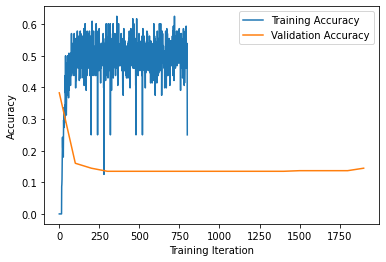

In [17]:
import matplotlib.pyplot as plt
plt.plot(range(len(training_accuracies)), training_accuracies, label = "Training Accuracy")
plt.plot(list(map(lambda x: x * 100, range(len(validation_accuracies)))), validation_accuracies, label = "Validation Accuracy")
plt.xlabel("Training Iteration")
plt.ylabel("Accuracy")
plt.legend()